# Data Prediction Using LSTM, GRU, and RNN

## Data Preparation

### Import all library used 

In [80]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
sc = MinMaxScaler(feature_range=(0,1)) #normalisasi dari 0 - 1

### Path for Data

In [8]:
data_path = "../data_after_prep"

### Get Data from path

In [9]:
list_data = os.listdir(data_path)
list_data

['ADRO2001-2407.csv',
 'AMMN2001-2407.csv',
 'AMRT2001-2407.csv',
 'ASII2001-2407.csv',
 'BBCA2001-2407.csv',
 'GOTO2001-2407.csv',
 'KLBF2001-2407.csv',
 'MAPI2001-2407.csv',
 'TLKM2001-2407.csv']

### Dataset for each stock code

In [10]:
ADRO = pd.read_csv(data_path + "/" + list_data[0], index_col='date', parse_dates=['date'])
AMMN = pd.read_csv(data_path + "/" + list_data[1], index_col='date', parse_dates=['date'])
AMRT = pd.read_csv(data_path + "/" + list_data[2], index_col='date', parse_dates=['date'])
ASII = pd.read_csv(data_path + "/" + list_data[3], index_col='date', parse_dates=['date'])
BBCA = pd.read_csv(data_path + "/" + list_data[4], index_col='date', parse_dates=['date'])
GOTO = pd.read_csv(data_path + "/" + list_data[5], index_col='date', parse_dates=['date'])
KLBF = pd.read_csv(data_path + "/" + list_data[6], index_col='date', parse_dates=['date'])
MAPI = pd.read_csv(data_path + "/" + list_data[7], index_col='date', parse_dates=['date'])
TLKM = pd.read_csv(data_path + "/" + list_data[8], index_col='date', parse_dates=['date'])



### Method for see data and see RMSE

In [93]:
# Some functions to help out with
def plot_predictions(stock_title,test,predicted, title):
    plt.plot(test, color='red',label='Real '+ stock_title+' Stock Price')
    plt.plot(predicted, color='blue',label='Predicted '+ stock_title+' Stock Price')
    plt.title(stock_title + ' Stock Price Prediction '+title)
    plt.xlabel('Time')
    plt.ylabel(stock_title +' Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def return_rmse_norm(test, pred):
    len_pred = len(pred)
    #pred = pred.reshape(len_pred)
    total = np.concatenate((pred, test))
    #total = total.reshape(-1,1)
    total = sc.fit_transform(total)
    arr_pred = total[len_pred:]
    arr_test = total[:len_pred]
    rmse = math.sqrt(mean_squared_error(arr_test, arr_pred))
    print("The root mean squared error after normalization is {}.".format(rmse))
    return rmse

### Result DataFrame

In [200]:
dic_res = {'stock' : [], 'term' : [], 'algorithm': [], 'rmse' : [], 'rmse_norm' : []}

## Short Term Predictions
Short term prediction using in this program is prediction in the week in a month.
Data use for this predictions is data in July 2024.
Data train and test is:
1. Data Train
    * Week 1: 1 - 5 July 2024
    * Week 2: 8 - 12 July 2024
    * Week 3: 15 - 19 July 2024
2. Data Test
    * Week 4: 22 - 26 July 2024 
    * Week 5: 29 - 31 July 2024

### ADRO

In [201]:
ADRO.head()

stock_code  open  high   low  close     volume
date                                                     
2020-01-02       ADRO  1555  1555  1490   1495   76612000
2020-01-03       ADRO  1495  1470  1425   1465  117795600
2020-01-06       ADRO  1465  1515  1450   1465   61423200
2020-01-07       ADRO  1465  1540  1460   1540   74336500
2020-01-08       ADRO  1540  1535  1505   1505   55121100

#### Data Split

In [202]:
ADRO_short_train = ADRO["2024-07-01":"2024-07-19"].iloc[:,3:4].values
ADRO_short_test = ADRO["2024-07-19":"2024-07-31"].iloc[:,3:4].values

##### Plot Train Test Data for ADRO

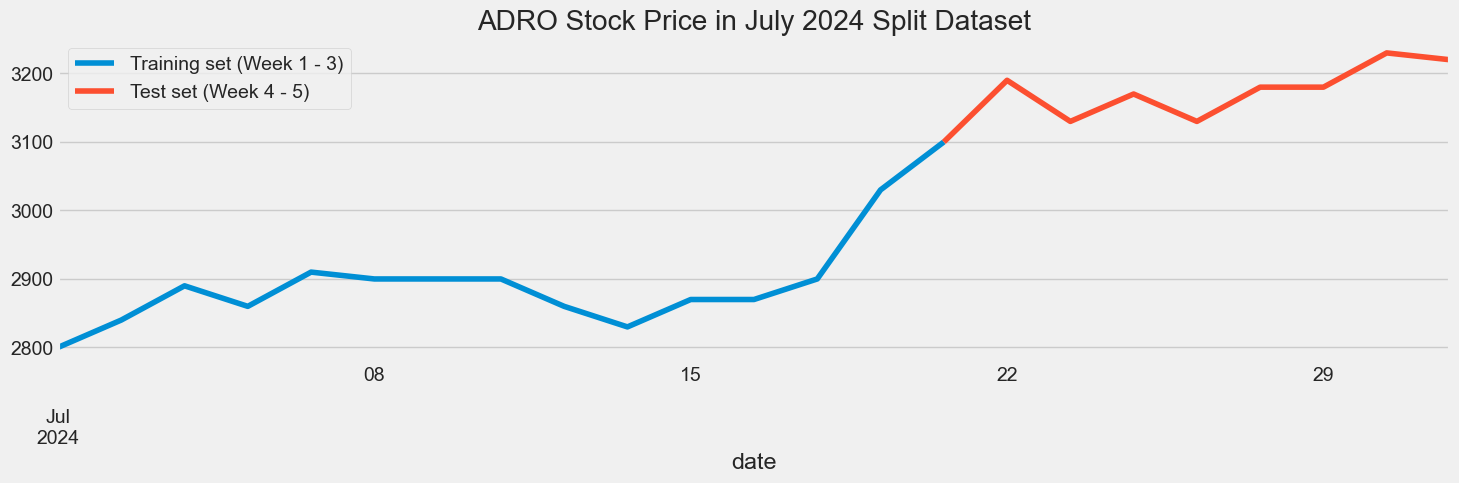

In [203]:
ADRO["close"]["2024-07-01":"2024-07-19"].plot(figsize=(16,4), legend=True)
ADRO["close"]["2024-07-19":"2024-07-31"].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Week 1 - 3)","Test set (Week 4 - 5)"])
plt.title('ADRO Stock Price in July 2024 Split Dataset')
plt.show()

##### Normalize Train Dataset

In [204]:
#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(ADRO_short_train)

##### Dataset Length

In [205]:
len_train = len(ADRO_short_train)
len_test = len(ADRO_short_test)
print(len_train, len_test)

15 9


#### LSTM Predictions

##### 5 Timestep Dataset Preparation

In [206]:
# Since LSTMs store long term memory state, we create a data structure with 5 timesteps and 1 output
# So for each element of training set, we have 5 previous training set elements 
X_train = []
y_train = []
for i in range(5,len_train):
    X_train.append(training_set_scaled[i-5:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

##### Reshaping


In [207]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

##### LSTM Architecture

In [208]:
# The LSTM architecture
regressorLSTM = Sequential()
# First LSTM layer with Dropout regularisation
regressorLSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorLSTM.add(Dropout(0.2))
# Second LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Third LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Fourth LSTM layer
regressorLSTM.add(LSTM(units=50))
regressorLSTM.add(Dropout(0.2))
# The output layer
regressorLSTM.add(Dense(units=1))

# Compiling the RNN
regressorLSTM.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
1/1 [==============================] - 15s 15s/step - loss: 0.2176
Epoch 2/50
1/1 [==============================] - 0s 29ms/step - loss: 0.1922
Epoch 3/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1727
Epoch 4/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1573
Epoch 5/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1359
Epoch 6/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1200
Epoch 7/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1022
Epoch 8/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0941
Epoch 9/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0709
Epoch 10/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0647
Epoch 11/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0568
Epoch 12/50
1/1 [==============================] - 0s 15ms/step - loss: 0.0498
Epoch 13/50
1/1 [==============================] - 0s 37ms/st

In [209]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 5 entires of test set have 5 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing

"""
ADRO_short_train = ADRO["2024-07-01":"2024-07-19"].iloc[:,3:4].values
ADRO_short_test = ADRO["2024-07-22":"2024-07-31"].iloc[:,3:4].values
"""
dataset_total = pd.concat((ADRO["close"]["2024-07-01":"2024-07-19"],ADRO["close"]["2024-07-19":"2024-07-31"]),axis=0)
inputs = dataset_total[len(dataset_total)-len(ADRO_short_test) - 5:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [210]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(5,len_test+5):
    X_test.append(inputs[i-5:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

1/1 [==============================] - 4s 4s/step


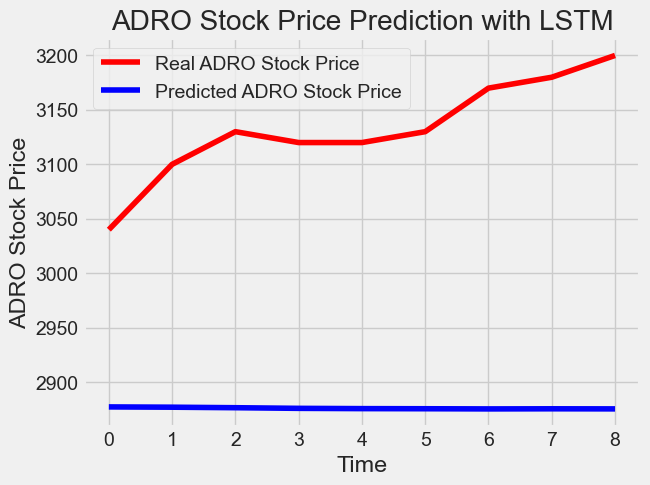

In [211]:
# Visualizing the results for LSTM
lstm_title = "with LSTM"
plot_predictions('ADRO', ADRO_short_test,LSTM_predicted_stock_price, lstm_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\2161622775.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = LSTM_predicted_stock_price


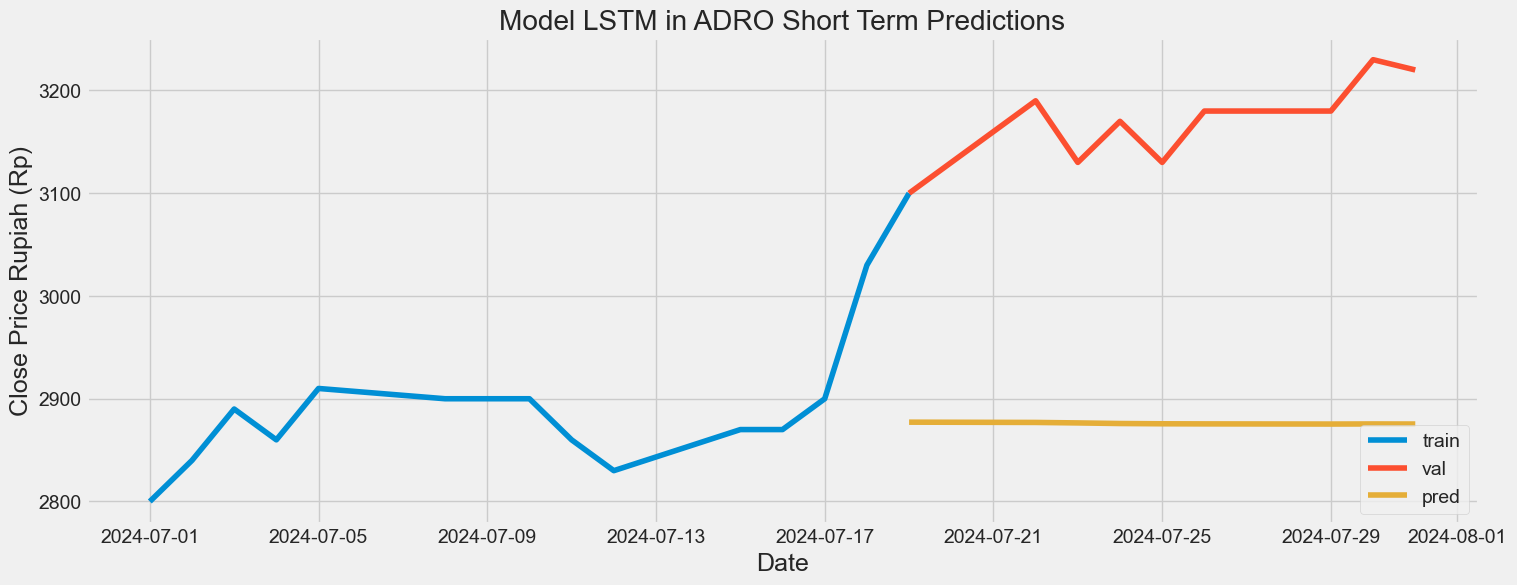

In [212]:
# Visualize the data
# Plot the data
train = ADRO["2024-07-01":"2024-07-19"]
valid = ADRO["2024-07-19":"2024-07-31"]
valid['pred'] = LSTM_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM in ADRO Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [213]:
# Evaluating the sequence
rmse = return_rmse(ADRO_short_test,LSTM_predicted_stock_price)
norm_rmse = return_rmse_norm(ADRO_short_test,LSTM_predicted_stock_price)
dic_res['stock'].append('ADRO')
dic_res['term'].append('short')
dic_res['algorithm'].append('LSTM')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 260.23580553636384.
The root mean squared error after normalization is 0.8016396848847667.


#### GRU Predictions

In [214]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
1/1 [==============================] - 15s 15s/step - loss: 0.2175
Epoch 2/50
1/1 [==============================] - 0s 20ms/step - loss: 0.1821
Epoch 3/50
1/1 [==============================] - 0s 30ms/step - loss: 0.1292
Epoch 4/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0774
Epoch 5/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0404
Epoch 6/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0502
Epoch 7/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0708
Epoch 8/50
1/1 [==============================] - 0s 21ms/step - loss: 0.0991
Epoch 9/50
1/1 [==============================] - 0s 21ms/step - loss: 0.1085
Epoch 10/50
1/1 [==============================] - 0s 30ms/step - loss: 0.1139
Epoch 11/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0844
Epoch 12/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0690
Epoch 13/50
1/1 [==============================] - 0s 25ms/st

In [215]:

GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

1/1 [==============================] - 3s 3s/step


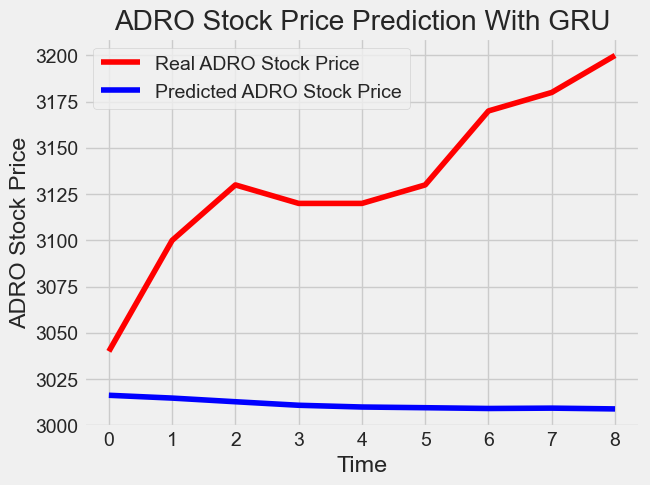

In [216]:
# Visualizing the results for GRU
gru_title = "With GRU"
plot_predictions("ADRO", ADRO_short_test,GRU_predicted_stock_price, gru_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\421449403.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = GRU_predicted_stock_price


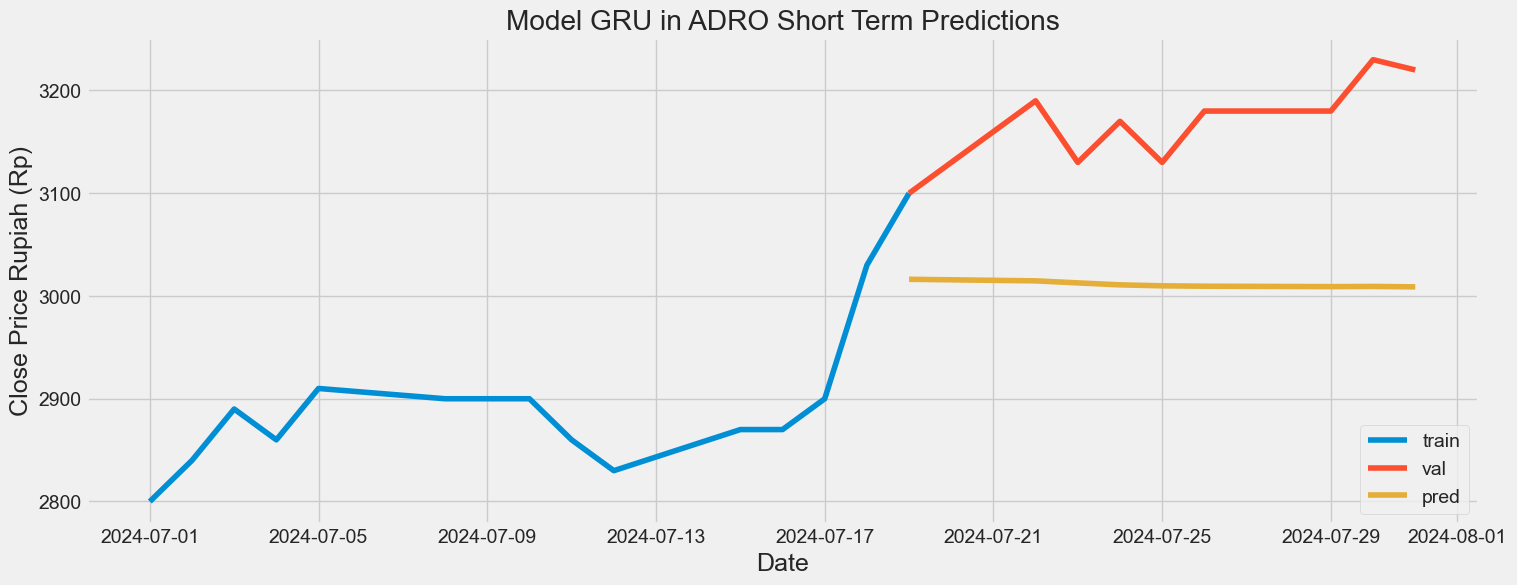

In [217]:
# Visualize the data
# Plot the data
train = ADRO["2024-07-01":"2024-07-19"]
valid = ADRO["2024-07-19":"2024-07-31"]
valid['pred'] = GRU_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model GRU in ADRO Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [218]:
# Evaluating the sequence

rmse = return_rmse(ADRO_short_test, GRU_predicted_stock_price)
norm_rmse = return_rmse_norm(ADRO_short_test, GRU_predicted_stock_price)
dic_res['stock'].append('ADRO')
dic_res['term'].append('short')
dic_res['algorithm'].append('GRU')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 129.8184582898852.
The root mean squared error after normalization is 0.6792549594932307.


#### RNN Predictions

In [220]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressorRNN = Sequential()

# adding first RNN layer and dropout regulatization
regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

regressorRNN.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding the output layer
regressorRNN.add(Dense(units = 1))

# compiling RNN
regressorRNN.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
history = regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)


Epoch 1/50
1/1 [==============================] - 7s 7s/step - loss: 0.5503 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 18ms/step - loss: 0.4017 - accuracy: 0.1000
Epoch 3/50
1/1 [==============================] - 0s 19ms/step - loss: 0.1850 - accuracy: 0.1000
Epoch 4/50
1/1 [==============================] - 0s 21ms/step - loss: 0.2895 - accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 20ms/step - loss: 0.3329 - accuracy: 0.1000
Epoch 6/50
1/1 [==============================] - 0s 20ms/step - loss: 0.3335 - accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 18ms/step - loss: 0.4009 - accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 20ms/step - loss: 0.2586 - accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 21ms/step - loss: 0.2545 - accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 21ms/step - loss: 0.3868 - accuracy: 0.0000e+00
Epo

In [221]:

RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)

1/1 [==============================] - 1s 1s/step


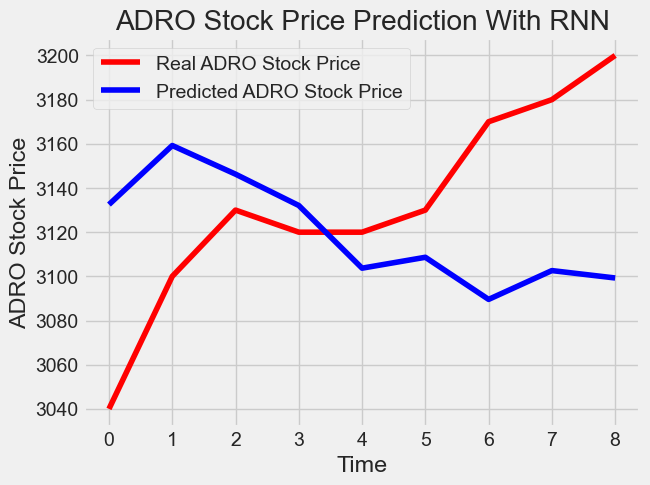

In [222]:
# Visualizing the results for GRU
rnn_title = "With RNN"
plot_predictions("ADRO", ADRO_short_test,RNN_predicted_stock_price, rnn_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\1127151966.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = RNN_predicted_stock_price


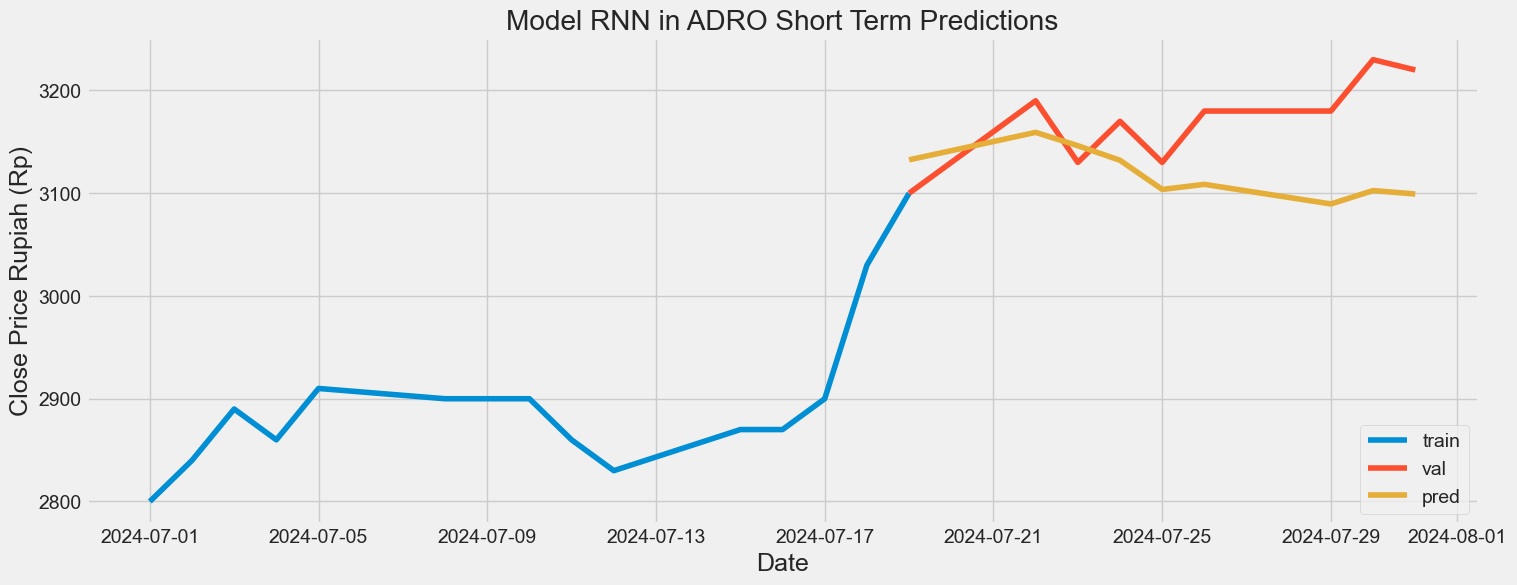

In [223]:
# Visualize the data
# Plot the data
train = ADRO["2024-07-01":"2024-07-19"]
valid = ADRO["2024-07-19":"2024-07-31"]
valid['pred'] = RNN_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model RNN in ADRO Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [224]:
# Evaluating the sequence
rmse = return_rmse(ADRO_short_test, RNN_predicted_stock_price)
norm_rmse = return_rmse_norm(ADRO_short_test, RNN_predicted_stock_price)
dic_res['stock'].append('ADRO')
dic_res['term'].append('short')
dic_res['algorithm'].append('RNN')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 63.07347965592974.
The root mean squared error after normalization is 0.3942092478495603.


### AMMN

#### Data Split

In [226]:
AMMN.head()

stock_code  open  high   low  close     volume
date                                                     
2023-07-07       AMMN  1695  1820  1700   1755  411565100
2023-07-10       AMMN  1755  1765  1745   1750   59010700
2023-07-11       AMMN  1750  1760  1750   1750   34028600
2023-07-12       AMMN  1750  1765  1750   1765   27860100
2023-07-13       AMMN  1765  1765  1750   1760   41745700

In [227]:
AMMN_short_train = AMMN["2024-07-01":"2024-07-19"].iloc[:,3:4].values
AMMN_short_test = AMMN["2024-07-19":"2024-07-31"].iloc[:,3:4].values

##### Plot Train Test Data for AMMN

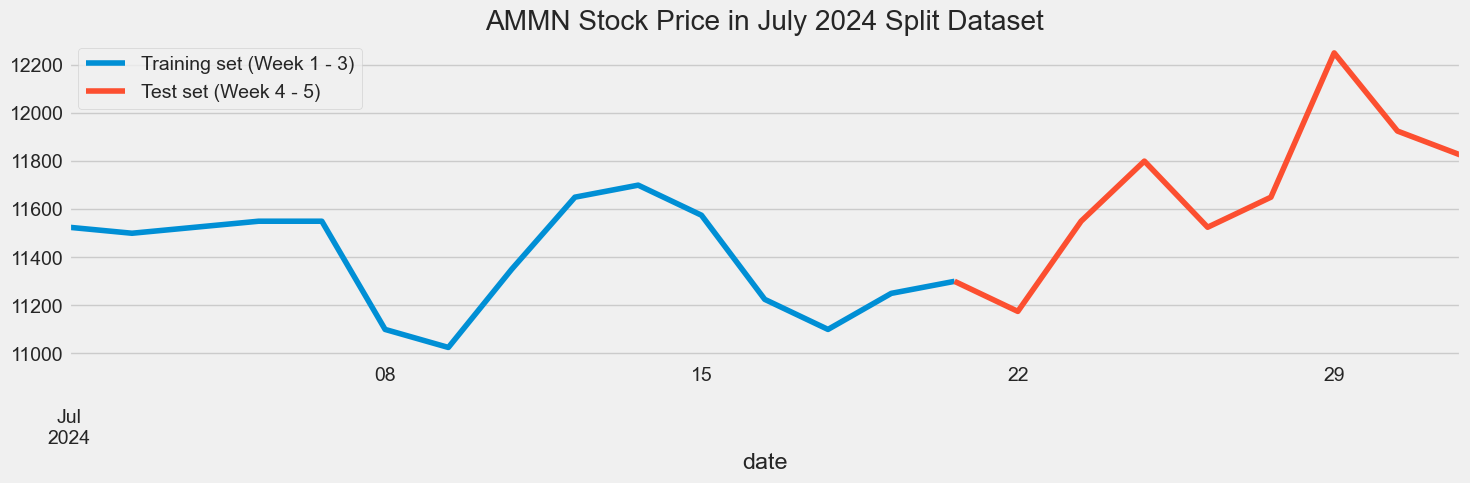

In [228]:
AMMN["close"]["2024-07-01":"2024-07-19"].plot(figsize=(16,4), legend=True)
AMMN["close"]["2024-07-19":"2024-07-31"].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Week 1 - 3)","Test set (Week 4 - 5)"])
plt.title('AMMN Stock Price in July 2024 Split Dataset')
plt.show()

In [229]:
#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(AMMN_short_train)
len_train = len(AMMN_short_train)
len_test = len(AMMN_short_test)
print(len_train, len_test)

15 9


In [230]:
# Since LSTMs store long term memory state, we create a data structure with 5 timesteps and 1 output
# So for each element of training set, we have 5 previous training set elements 
X_train = []
y_train = []
for i in range(5,len_train):
    X_train.append(training_set_scaled[i-5:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [232]:
dataset_total = pd.concat((AMMN["close"]["2024-07-01":"2024-07-19"],AMMN["close"]["2024-07-19":"2024-07-31"]),axis=0)
inputs = dataset_total[len(dataset_total)-len(AMMN_short_test) - 5:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

#### LSTM Predictions

In [231]:
regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
1/1 [==============================] - 0s 32ms/step - loss: 0.1254
Epoch 2/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0807
Epoch 3/50
1/1 [==============================] - 0s 30ms/step - loss: 0.1111
Epoch 4/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0964
Epoch 5/50
1/1 [==============================] - 0s 36ms/step - loss: 0.0817
Epoch 6/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0922
Epoch 7/50
1/1 [==============================] - 0s 50ms/step - loss: 0.0803
Epoch 8/50
1/1 [==============================] - 0s 40ms/step - loss: 0.0902
Epoch 9/50
1/1 [==============================] - 0s 40ms/step - loss: 0.0944
Epoch 10/50
1/1 [==============================] - 0s 42ms/step - loss: 0.0806
Epoch 11/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0870
Epoch 12/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0960
Epoch 13/50
1/1 [==============================] - 0s 29ms/st

In [233]:
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

1/1 [==============================] - 0s 50ms/step


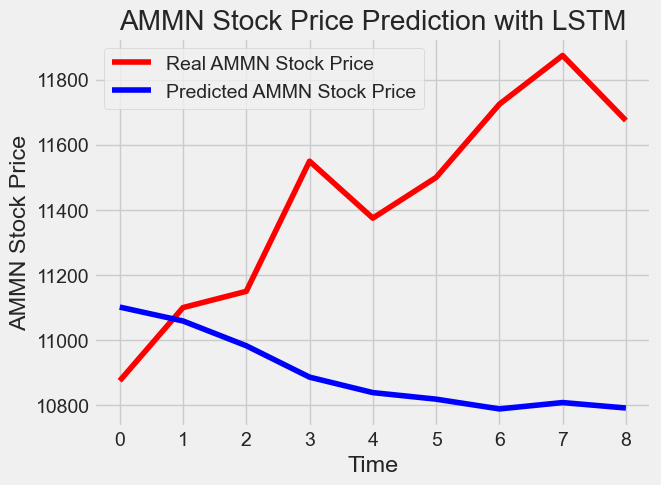

In [234]:
# Visualizing the results for LSTM
lstm_title = "with LSTM"
plot_predictions('AMMN', AMMN_short_test,LSTM_predicted_stock_price, lstm_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\3088982548.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = LSTM_predicted_stock_price


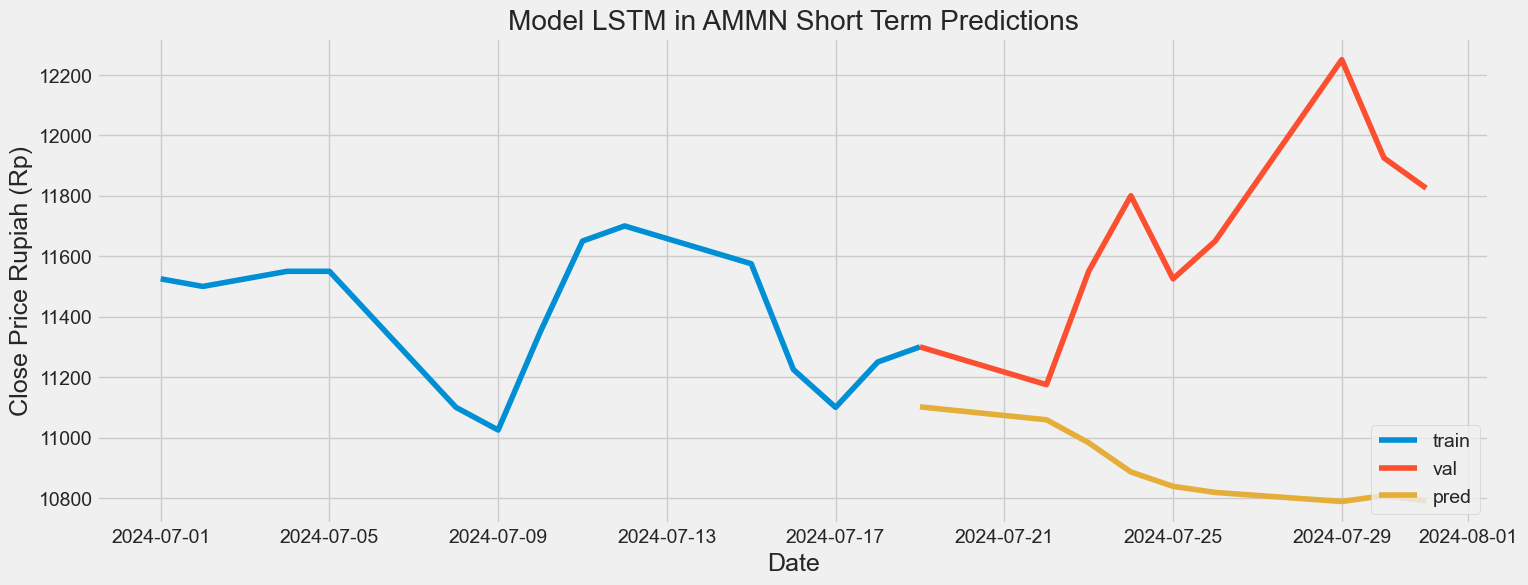

In [235]:
# Visualize the data
# Plot the data
train = AMMN["2024-07-01":"2024-07-19"]
valid = AMMN["2024-07-19":"2024-07-31"]
valid['pred'] = LSTM_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM in AMMN Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [236]:
# Evaluating the sequence
rmse = return_rmse(AMMN_short_test,LSTM_predicted_stock_price)
norm_rmse = return_rmse_norm(AMMN_short_test,LSTM_predicted_stock_price)
dic_res['stock'].append('AMMN')
dic_res['term'].append('short')
dic_res['algorithm'].append('LSTM')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 672.4466932634908.
The root mean squared error after normalization is 0.618947617461249.


#### GRU Predictions

In [238]:
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
1/1 [==============================] - 0s 33ms/step - loss: 0.1099
Epoch 2/50
1/1 [==============================] - 0s 36ms/step - loss: 0.0942
Epoch 3/50
1/1 [==============================] - 0s 38ms/step - loss: 0.1099
Epoch 4/50
1/1 [==============================] - 0s 37ms/step - loss: 0.0830
Epoch 5/50
1/1 [==============================] - 0s 35ms/step - loss: 0.0935
Epoch 6/50
1/1 [==============================] - 0s 43ms/step - loss: 0.0866
Epoch 7/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0769
Epoch 8/50
1/1 [==============================] - 0s 35ms/step - loss: 0.0925
Epoch 9/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0834
Epoch 10/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0936
Epoch 11/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1116
Epoch 12/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0969
Epoch 13/50
1/1 [==============================] - 0s 32ms/st

In [239]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

1/1 [==============================] - 0s 70ms/step


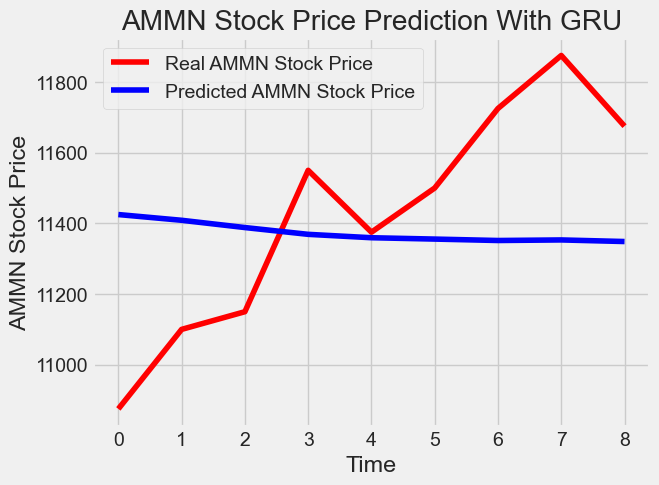

In [241]:
# Visualizing the results for GRU
gru_title = "With GRU"
plot_predictions("AMMN", AMMN_short_test,GRU_predicted_stock_price, gru_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\197209116.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = GRU_predicted_stock_price


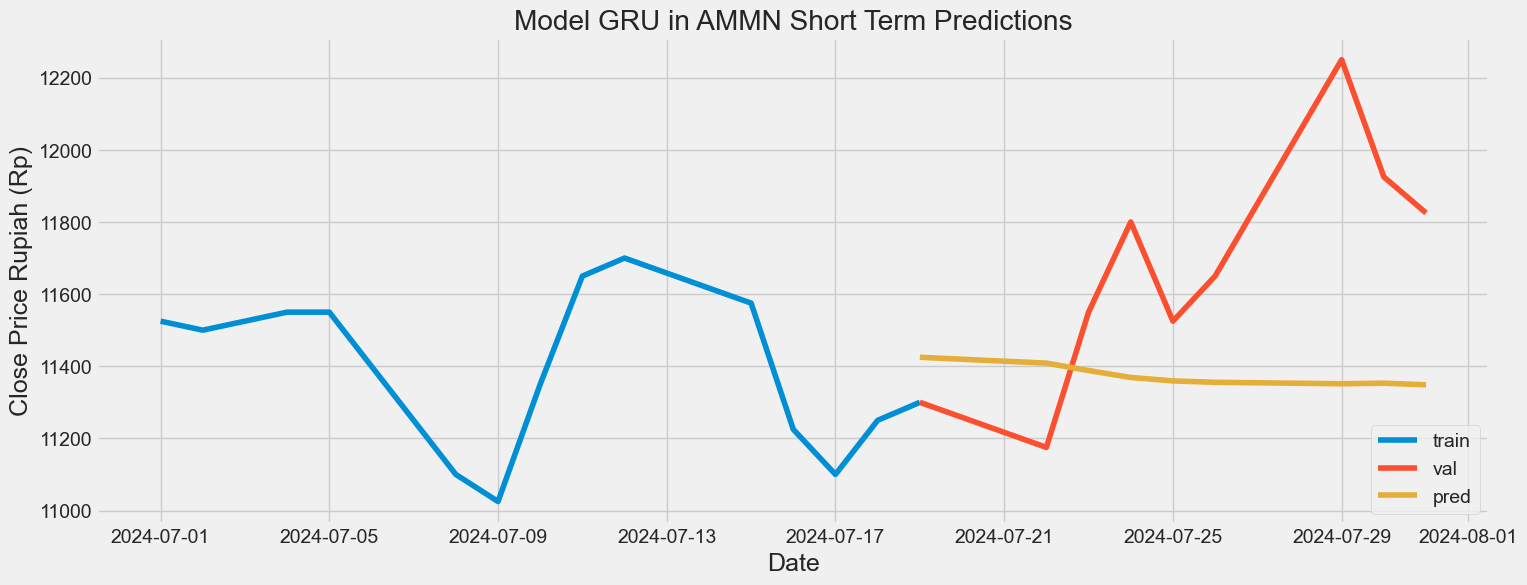

In [240]:
# Visualize the data
# Plot the data
train = AMMN["2024-07-01":"2024-07-19"]
valid = AMMN["2024-07-19":"2024-07-31"]
valid['pred'] = GRU_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model GRU in AMMN Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [242]:
# Evaluating the sequence

rmse = return_rmse(AMMN_short_test, GRU_predicted_stock_price)
norm_rmse = return_rmse_norm(AMMN_short_test, GRU_predicted_stock_price)
dic_res['stock'].append('AMMN')
dic_res['term'].append('short')
dic_res['algorithm'].append('GRU')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 337.763557461126.
The root mean squared error after normalization is 0.33776355746112613.


#### RNN Predictions

In [244]:
regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3281 - accuracy: 0.1000
Epoch 2/50
1/1 [==============================] - 0s 13ms/step - loss: 0.1970 - accuracy: 0.1000
Epoch 3/50
1/1 [==============================] - 0s 19ms/step - loss: 0.3391 - accuracy: 0.1000
Epoch 4/50
1/1 [==============================] - 0s 17ms/step - loss: 0.2635 - accuracy: 0.1000
Epoch 5/50
1/1 [==============================] - 0s 16ms/step - loss: 0.1968 - accuracy: 0.2000
Epoch 6/50
1/1 [==============================] - 0s 18ms/step - loss: 0.3157 - accuracy: 0.1000
Epoch 7/50
1/1 [==============================] - 0s 23ms/step - loss: 0.5727 - accuracy: 0.1000
Epoch 8/50
1/1 [==============================] - 0s 19ms/step - loss: 0.3550 - accuracy: 0.1000
Epoch 9/50
1/1 [==============================] - 0s 16ms/step - loss: 0.3722 - accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 20ms/step - loss: 0.2173 - accuracy: 0.0000e+00
Epoch 11/50
1/1 [====

In [245]:
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)

1/1 [==============================] - 0s 52ms/step


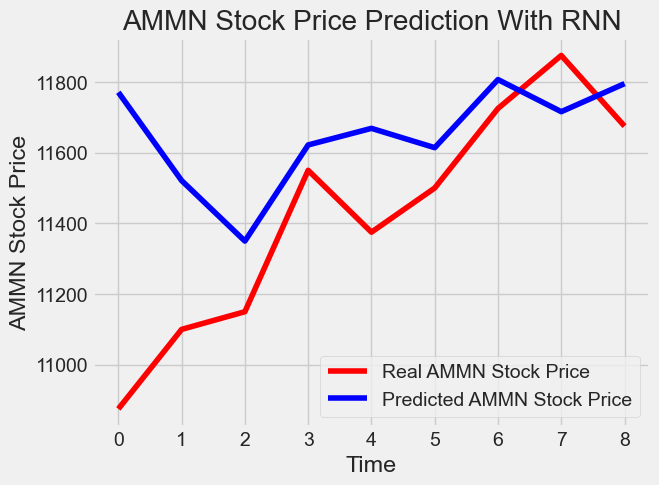

In [246]:
# Visualizing the results for RNN
rnn_title = "With RNN"
plot_predictions("AMMN", AMMN_short_test,RNN_predicted_stock_price, rnn_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\3390390207.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = RNN_predicted_stock_price


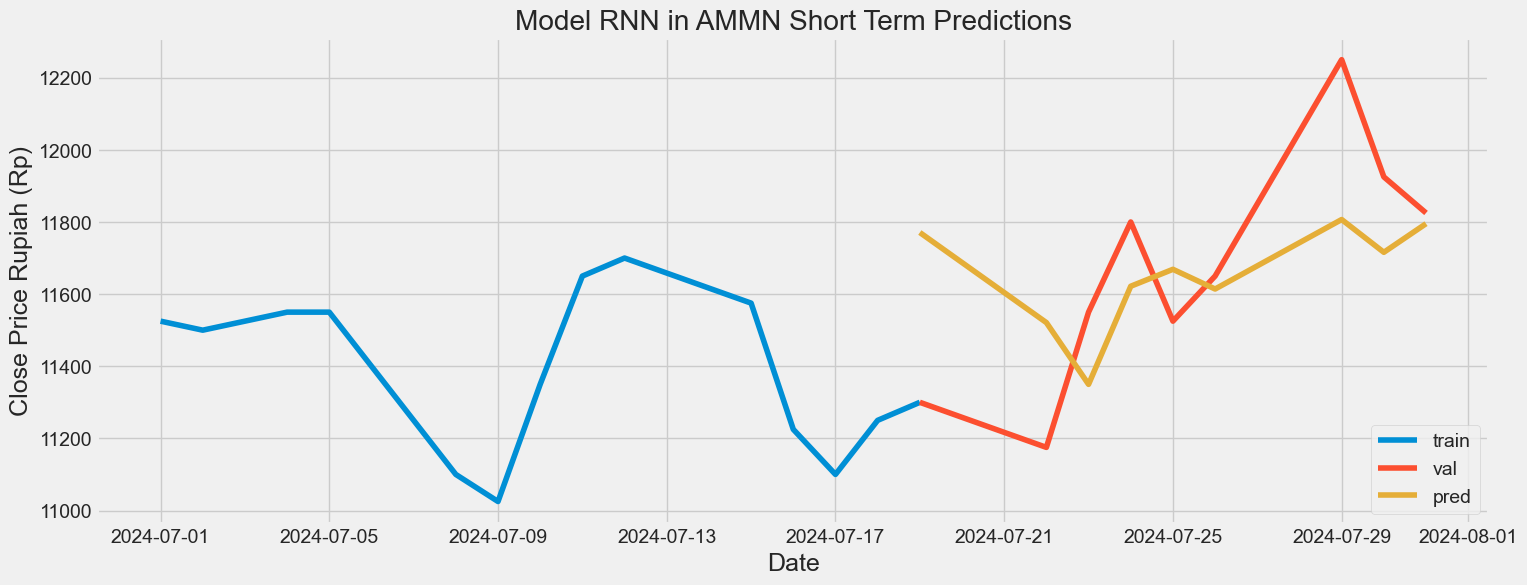

In [247]:
# Visualize the data
# Plot the data
train = AMMN["2024-07-01":"2024-07-19"]
valid = AMMN["2024-07-19":"2024-07-31"]
valid['pred'] = RNN_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model RNN in AMMN Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [248]:
# Evaluating the sequence
rmse = return_rmse(AMMN_short_test, RNN_predicted_stock_price)
norm_rmse = return_rmse_norm(AMMN_short_test, RNN_predicted_stock_price)
dic_res['stock'].append('AMMN')
dic_res['term'].append('short')
dic_res['algorithm'].append('RNN')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 360.6386700074632.
The root mean squared error after normalization is 0.36063867000746336.


### AMRT

In [250]:
AMRT.head()

stock_code  open  high  low  close  volume
date                                                 
2020-01-02       AMRT   880   880  855    875    9600
2020-01-03       AMRT   875   880  855    865   51800
2020-01-06       AMRT   865   865  845    845   42000
2020-01-07       AMRT   845   850  840    840   20500
2020-01-08       AMRT   840   855  840    855  568500

#### Data Split

In [251]:
AMRT_short_train = AMRT["2024-07-01":"2024-07-19"].iloc[:,3:4].values
AMRT_short_test = AMRT["2024-07-19":"2024-07-31"].iloc[:,3:4].values

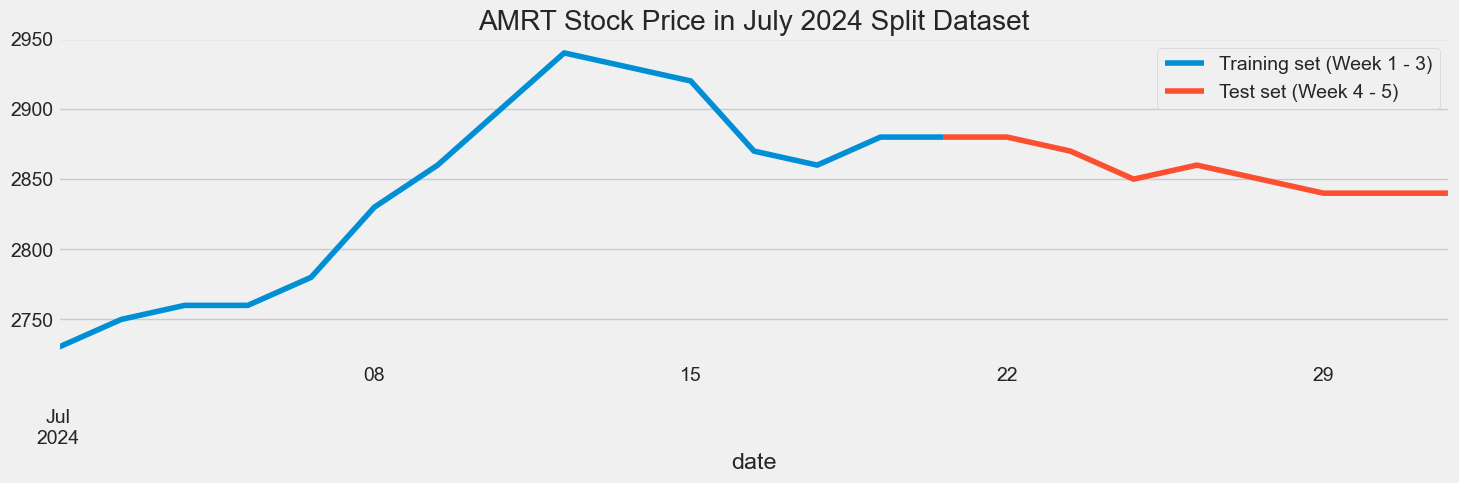

In [252]:
AMRT["close"]["2024-07-01":"2024-07-19"].plot(figsize=(16,4), legend=True)
AMRT["close"]["2024-07-19":"2024-07-31"].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Week 1 - 3)","Test set (Week 4 - 5)"])
plt.title('AMRT Stock Price in July 2024 Split Dataset')
plt.show()

In [253]:
#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(AMRT_short_train)
len_train = len(AMRT_short_train)
len_test = len(AMRT_short_test)
print(len_train, len_test)

# Since LSTMs store long term memory state, we create a data structure with 5 timesteps and 1 output
# So for each element of training set, we have 5 previous training set elements 
X_train = []
y_train = []
for i in range(5,len_train):
    X_train.append(training_set_scaled[i-5:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

dataset_total = pd.concat((AMRT["close"]["2024-07-01":"2024-07-19"],AMRT["close"]["2024-07-19":"2024-07-31"]),axis=0)
inputs = dataset_total[len(dataset_total)-len(AMRT_short_test) - 5:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

15 9


#### LSTM Predictions

In [254]:
regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
1/1 [==============================] - 0s 33ms/step - loss: 0.0645
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0498
Epoch 3/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0472
Epoch 4/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0543
Epoch 5/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0539
Epoch 6/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0631
Epoch 7/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0590
Epoch 8/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0511
Epoch 9/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0621
Epoch 10/50
1/1 [==============================] - 0s 34ms/step - loss: 0.0573
Epoch 11/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0664
Epoch 12/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0608
Epoch 13/50
1/1 [==============================] - 0s 28ms/st

In [255]:
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

1/1 [==============================] - 0s 64ms/step


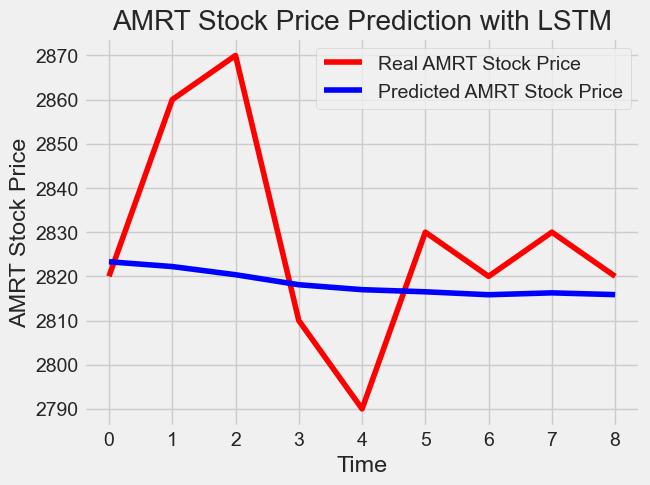

In [259]:
# Visualizing the results for LSTM
lstm_title = "with LSTM"
plot_predictions('AMRT', AMRT_short_test,LSTM_predicted_stock_price, lstm_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\566703989.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = LSTM_predicted_stock_price


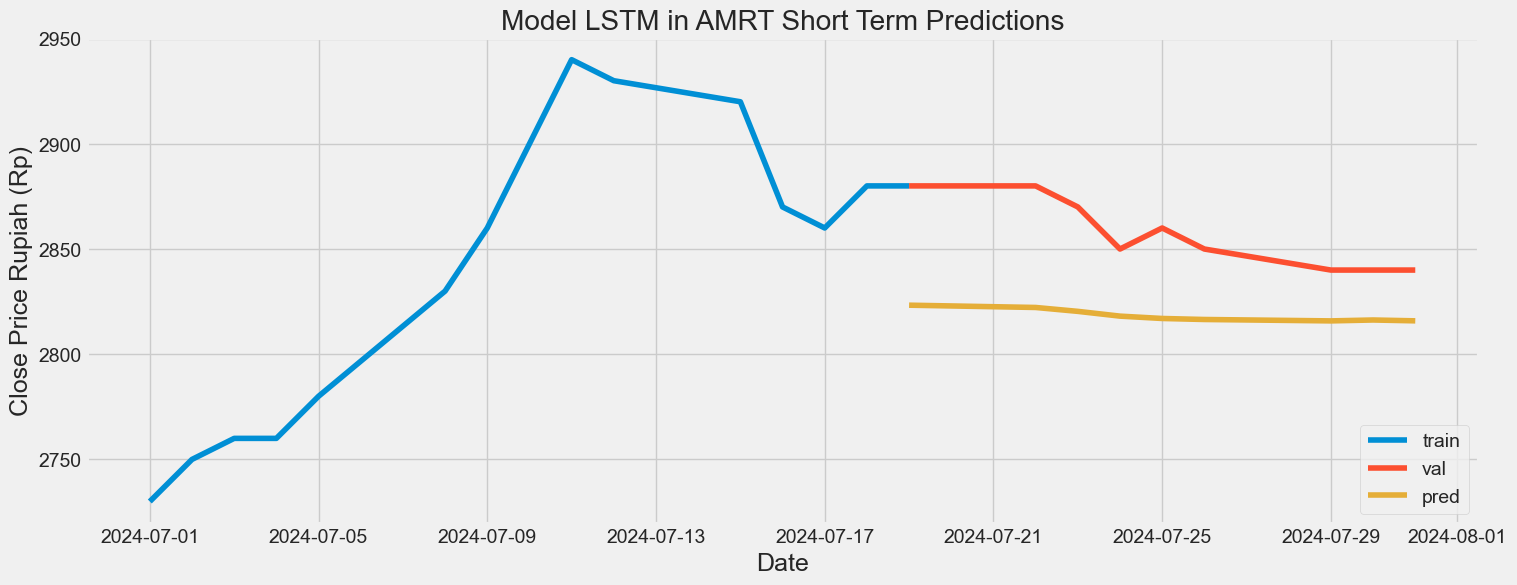

In [260]:
# Visualize the data
# Plot the data
train = AMRT["2024-07-01":"2024-07-19"]
valid = AMRT["2024-07-19":"2024-07-31"]
valid['pred'] = LSTM_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM in AMRT Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [261]:
# Evaluating the sequence
rmse = return_rmse(AMRT_short_test,LSTM_predicted_stock_price)
norm_rmse = return_rmse_norm(AMRT_short_test,LSTM_predicted_stock_price)
dic_res['stock'].append('AMRT')
dic_res['term'].append('short')
dic_res['algorithm'].append('LSTM')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 23.80564250309468.
The root mean squared error after normalization is 0.297570531288683.


#### GRU Predictions

In [263]:
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
1/1 [==============================] - 0s 34ms/step - loss: 0.0474
Epoch 2/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0536
Epoch 3/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0563
Epoch 4/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0559
Epoch 5/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0572
Epoch 6/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0560
Epoch 7/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0557
Epoch 8/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0624
Epoch 9/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0554
Epoch 10/50
1/1 [==============================] - 0s 31ms/step - loss: 0.0633
Epoch 11/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0583
Epoch 12/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0450
Epoch 13/50
1/1 [==============================] - 0s 26ms/st

In [264]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

1/1 [==============================] - 0s 64ms/step


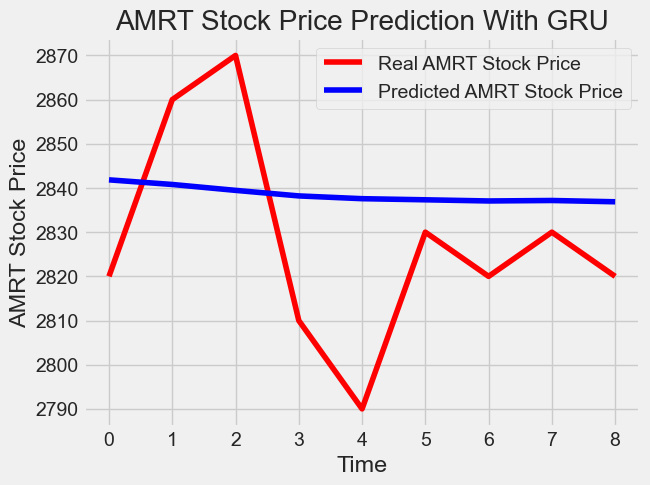

In [265]:
# Visualizing the results for GRU
gru_title = "With GRU"
plot_predictions("AMRT", AMRT_short_test,GRU_predicted_stock_price, gru_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\73124917.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = GRU_predicted_stock_price


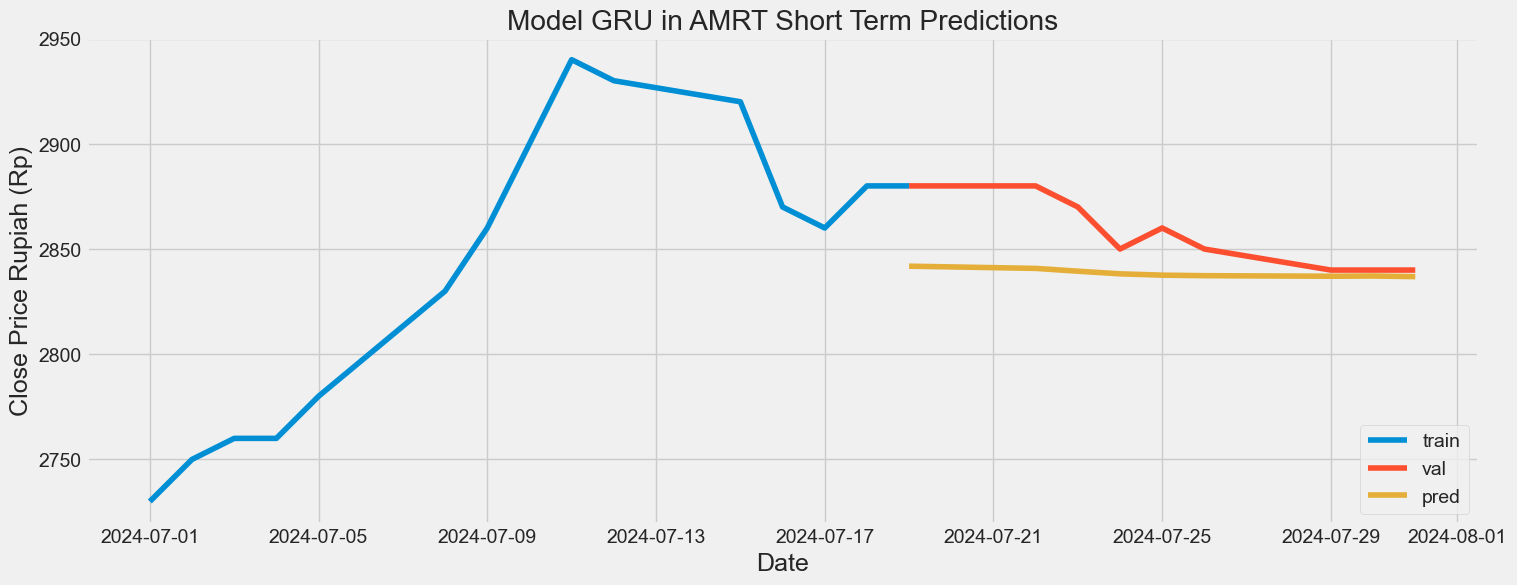

In [266]:
# Visualize the data
# Plot the data
train = AMRT["2024-07-01":"2024-07-19"]
valid = AMRT["2024-07-19":"2024-07-31"]
valid['pred'] = GRU_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model GRU in AMRT Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [267]:
# Evaluating the sequence

rmse = return_rmse(AMRT_short_test, GRU_predicted_stock_price)
norm_rmse = return_rmse_norm(AMRT_short_test, GRU_predicted_stock_price)
dic_res['stock'].append('AMRT')
dic_res['term'].append('short')
dic_res['algorithm'].append('GRU')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 24.76478042499507.
The root mean squared error after normalization is 0.309559755312438.


#### RNN Predictions

In [268]:
regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2608 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 16ms/step - loss: 0.1748 - accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 25ms/step - loss: 0.2702 - accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1712 - accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1439 - accuracy: 0.1000
Epoch 6/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1459 - accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 35ms/step - loss: 0.1414 - accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1088 - accuracy: 0.1000
Epoch 9/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1946 - accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0444 - accuracy: 0.0000e+

In [269]:
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)

1/1 [==============================] - 0s 43ms/step


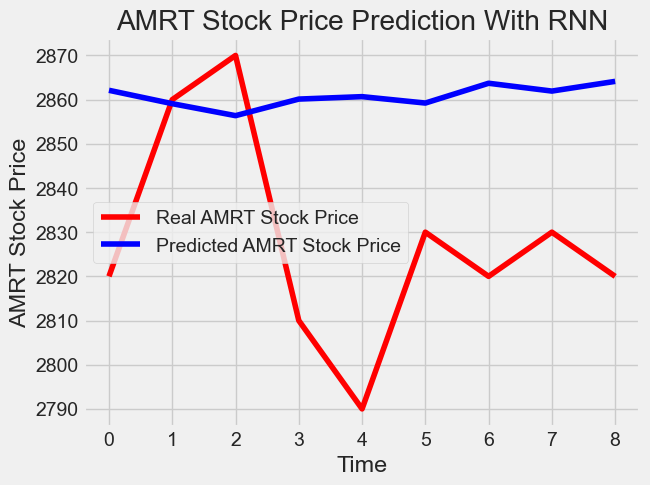

In [270]:
# Visualizing the results for RNN
rnn_title = "With RNN"
plot_predictions("AMRT", AMRT_short_test,RNN_predicted_stock_price, rnn_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\486554037.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = RNN_predicted_stock_price


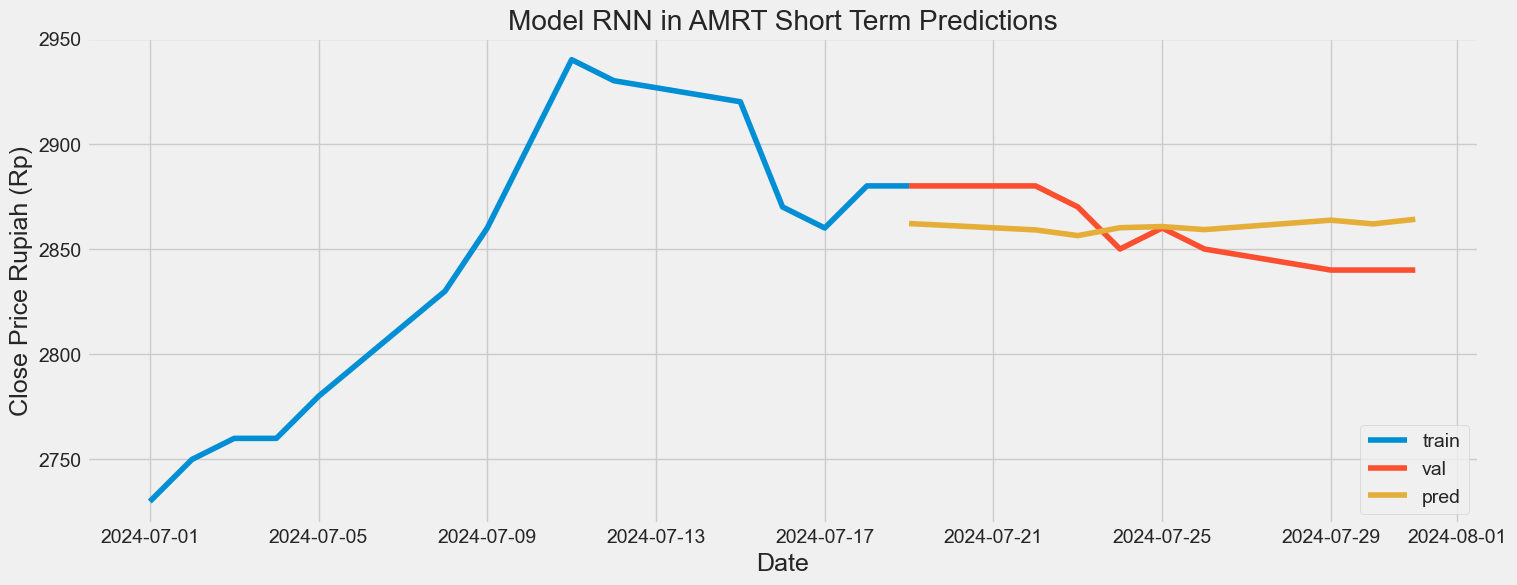

In [271]:
# Visualize the data
# Plot the data
train = AMRT["2024-07-01":"2024-07-19"]
valid = AMRT["2024-07-19":"2024-07-31"]
valid['pred'] = RNN_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model RNN in AMRT Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [272]:
# Evaluating the sequence
rmse = return_rmse(AMRT_short_test, RNN_predicted_stock_price)
norm_rmse = return_rmse_norm(AMRT_short_test, RNN_predicted_stock_price)
dic_res['stock'].append('AMRT')
dic_res['term'].append('short')
dic_res['algorithm'].append('RNN')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 41.096781513192.
The root mean squared error after normalization is 0.5137097689149004.


### ASII

In [273]:
ASII.head()

stock_code  open  high   low  close    volume
date                                                    
2020-01-02       ASII  6925  6925  6775   6875  15008600
2020-01-03       ASII  6875  6950  6825   6950  19068800
2020-01-06       ASII  6950  6900  6750   6750  22261900
2020-01-07       ASII  6750  6825  6675   6775  27963000
2020-01-08       ASII  6775  6825  6700   6775  15150400

#### Data Split

In [274]:
ASII_short_train = ASII["2024-07-01":"2024-07-19"].iloc[:,3:4].values
ASII_short_test = ASII["2024-07-19":"2024-07-31"].iloc[:,3:4].values

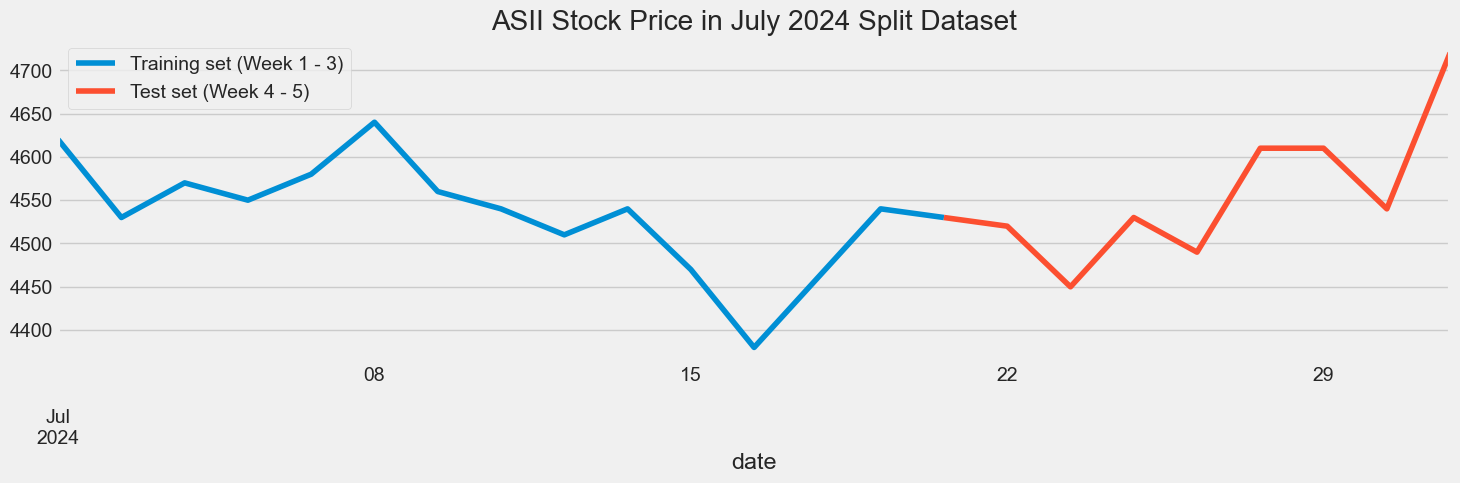

In [275]:
ASII["close"]["2024-07-01":"2024-07-19"].plot(figsize=(16,4), legend=True)
ASII["close"]["2024-07-19":"2024-07-31"].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Week 1 - 3)","Test set (Week 4 - 5)"])
plt.title('ASII Stock Price in July 2024 Split Dataset')
plt.show()

In [276]:
#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(ASII_short_train)
len_train = len(ASII_short_train)
len_test = len(ASII_short_test)
print(len_train, len_test)

# Since LSTMs store long term memory state, we create a data structure with 5 timesteps and 1 output
# So for each element of training set, we have 5 previous training set elements 
X_train = []
y_train = []
for i in range(5,len_train):
    X_train.append(training_set_scaled[i-5:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

dataset_total = pd.concat((ASII["close"]["2024-07-01":"2024-07-19"],ASII["close"]["2024-07-19":"2024-07-31"]),axis=0)
inputs = dataset_total[len(dataset_total)-len(ASII_short_test) - 5:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

15 9


#### LSTM Predictions

In [277]:
regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
1/1 [==============================] - 0s 59ms/step - loss: 0.1035
Epoch 2/50
1/1 [==============================] - 0s 43ms/step - loss: 0.1008
Epoch 3/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0987
Epoch 4/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0964
Epoch 5/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0876
Epoch 6/50
1/1 [==============================] - 0s 103ms/step - loss: 0.1003
Epoch 7/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0808
Epoch 8/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0785
Epoch 9/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1026
Epoch 10/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0891
Epoch 11/50
1/1 [==============================] - 0s 21ms/step - loss: 0.0846
Epoch 12/50
1/1 [==============================] - 0s 21ms/step - loss: 0.0962
Epoch 13/50
1/1 [==============================] - 0s 22ms/s

In [278]:
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

1/1 [==============================] - 0s 57ms/step


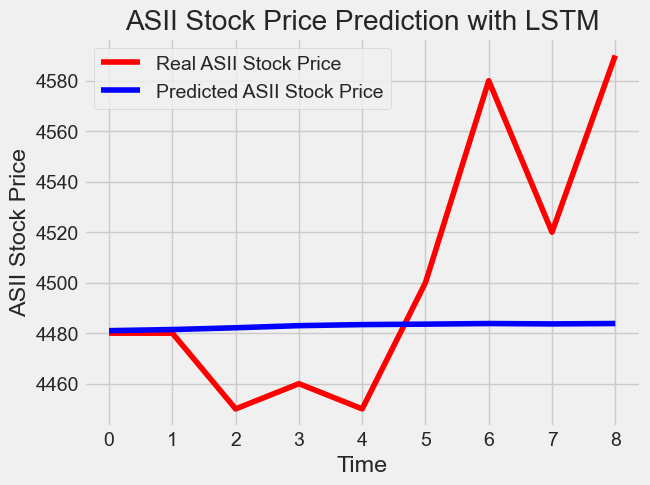

In [279]:
# Visualizing the results for LSTM
lstm_title = "with LSTM"
plot_predictions('ASII', ASII_short_test,LSTM_predicted_stock_price, lstm_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\2824440461.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = LSTM_predicted_stock_price


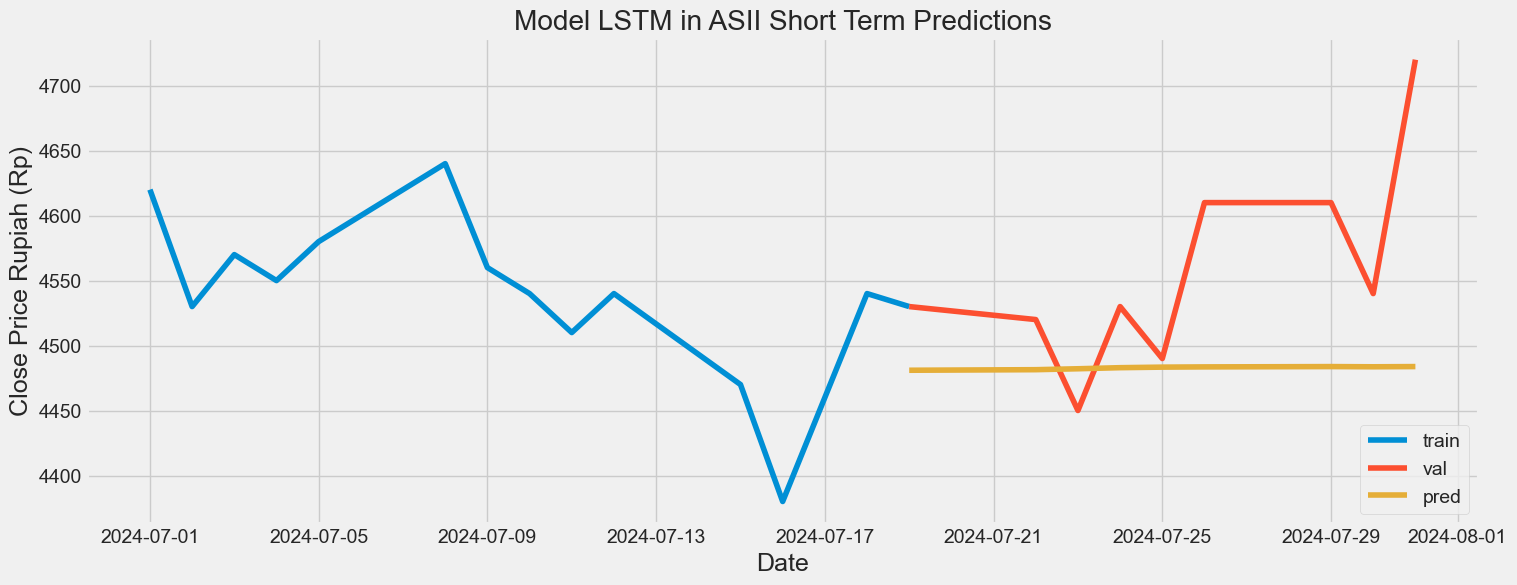

In [280]:
# Visualize the data
# Plot the data
train = ASII["2024-07-01":"2024-07-19"]
valid = ASII["2024-07-19":"2024-07-31"]
valid['pred'] = LSTM_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM in ASII Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [281]:
# Evaluating the sequence
rmse = return_rmse(ASII_short_test,LSTM_predicted_stock_price)
norm_rmse = return_rmse_norm(ASII_short_test,LSTM_predicted_stock_price)
dic_res['stock'].append('ASII')
dic_res['term'].append('short')
dic_res['algorithm'].append('LSTM')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 52.484504888318995.
The root mean squared error after normalization is 0.37488932063085056.


#### GRU Predictions

In [282]:
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
1/1 [==============================] - 0s 34ms/step - loss: 0.1090
Epoch 2/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1040
Epoch 3/50
1/1 [==============================] - 0s 46ms/step - loss: 0.1005
Epoch 4/50
1/1 [==============================] - 0s 52ms/step - loss: 0.1082
Epoch 5/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0976
Epoch 6/50
1/1 [==============================] - 0s 53ms/step - loss: 0.1003
Epoch 7/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0938
Epoch 8/50
1/1 [==============================] - 0s 36ms/step - loss: 0.1022
Epoch 9/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0978
Epoch 10/50
1/1 [==============================] - 0s 30ms/step - loss: 0.1027
Epoch 11/50
1/1 [==============================] - 0s 30ms/step - loss: 0.1051
Epoch 12/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1038
Epoch 13/50
1/1 [==============================] - 0s 34ms/st

In [283]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

1/1 [==============================] - 0s 60ms/step


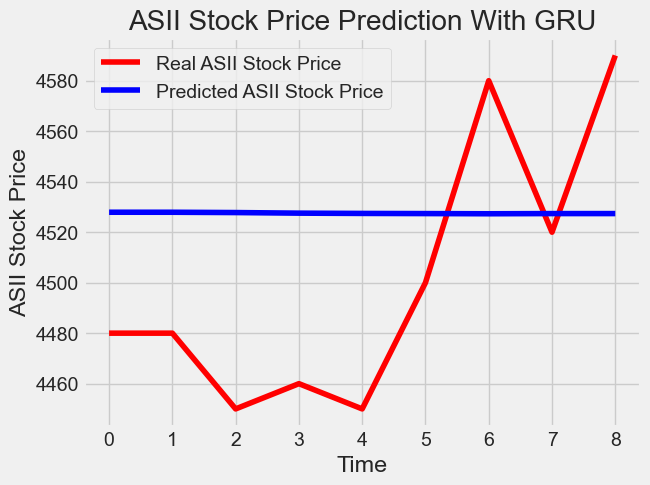

In [284]:
# Visualizing the results for GRU
gru_title = "With GRU"
plot_predictions("ASII", ASII_short_test,GRU_predicted_stock_price, gru_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\864325195.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = GRU_predicted_stock_price


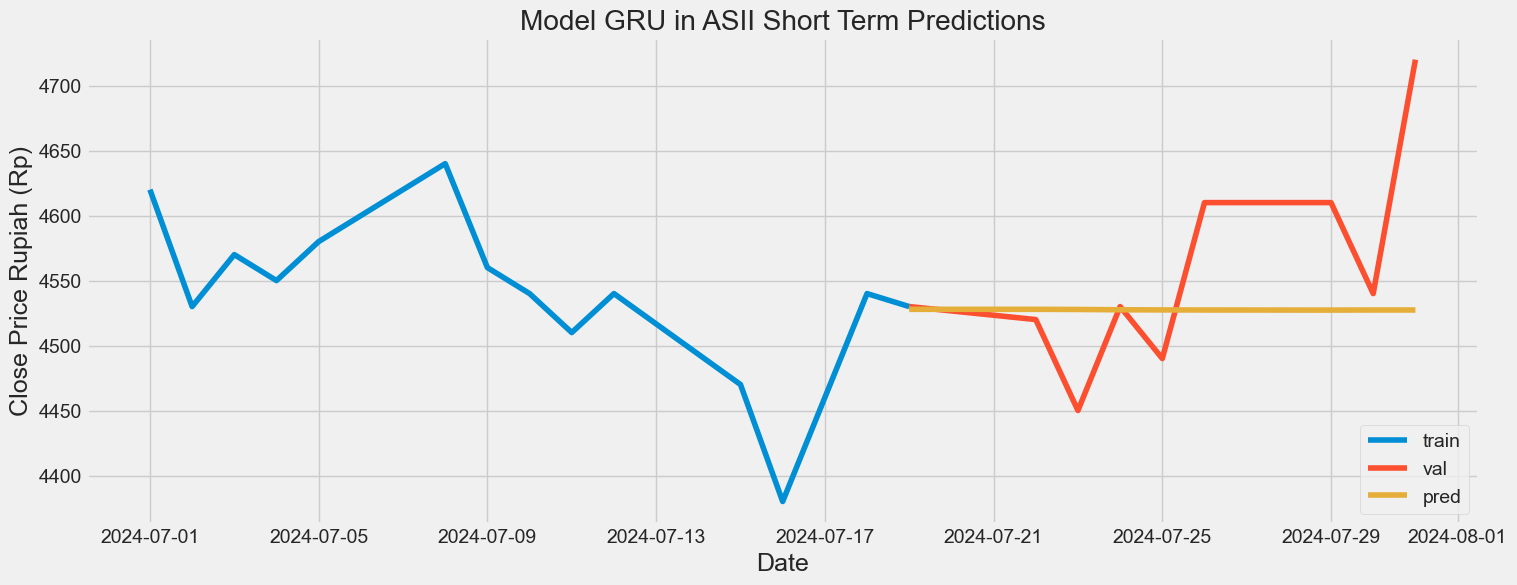

In [285]:
# Visualize the data
# Plot the data
train = ASII["2024-07-01":"2024-07-19"]
valid = ASII["2024-07-19":"2024-07-31"]
valid['pred'] = GRU_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model GRU in ASII Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [286]:
# Evaluating the sequence

rmse = return_rmse(ASII_short_test, GRU_predicted_stock_price)
norm_rmse = return_rmse_norm(ASII_short_test, GRU_predicted_stock_price)
dic_res['stock'].append('ASII')
dic_res['term'].append('short')
dic_res['algorithm'].append('GRU')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 56.46746559303176.
The root mean squared error after normalization is 0.40333903995022613.


#### RNN Predictions

In [287]:
regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
1/1 [==============================] - 0s 29ms/step - loss: 0.2095 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 21ms/step - loss: 0.0975 - accuracy: 0.1000
Epoch 3/50
1/1 [==============================] - 0s 17ms/step - loss: 0.1676 - accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1535 - accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 16ms/step - loss: 0.0977 - accuracy: 0.2000
Epoch 6/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2963 - accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 90ms/step - loss: 0.1435 - accuracy: 0.2000
Epoch 8/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0654 - accuracy: 0.2000
Epoch 9/50
1/1 [==============================] - 0s 19ms/step - loss: 0.3065 - accuracy: 0.1000
Epoch 10/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1516 - accuracy: 0.2000
Epoch 11/50
1

In [288]:
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)

1/1 [==============================] - 0s 49ms/step


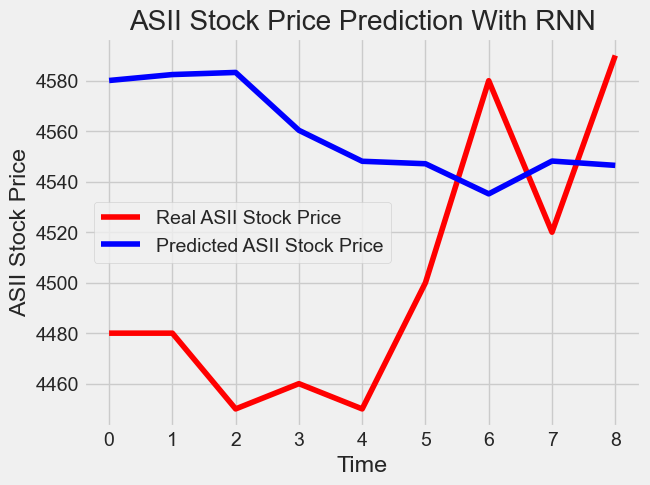

In [289]:
# Visualizing the results for RNN
rnn_title = "With RNN"
plot_predictions("ASII", ASII_short_test,RNN_predicted_stock_price, rnn_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\203231731.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = RNN_predicted_stock_price


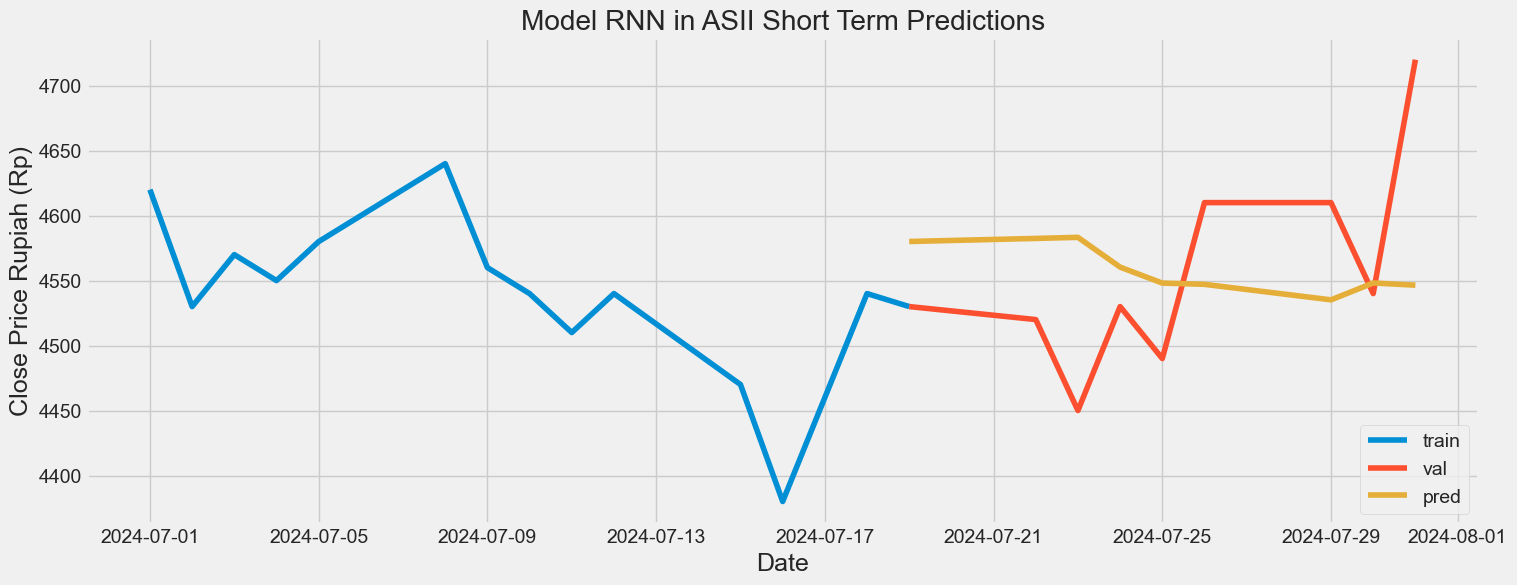

In [291]:
# Visualize the data
# Plot the data
train = ASII["2024-07-01":"2024-07-19"]
valid = ASII["2024-07-19":"2024-07-31"]
valid['pred'] = RNN_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model RNN in ASII Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [292]:
# Evaluating the sequence
rmse = return_rmse(ASII_short_test, RNN_predicted_stock_price)
norm_rmse = return_rmse_norm(ASII_short_test, RNN_predicted_stock_price)
dic_res['stock'].append('ASII')
dic_res['term'].append('short')
dic_res['algorithm'].append('RNN')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 84.9058580613765.
The root mean squared error after normalization is 0.6064704147241183.


### GOTO

In [293]:
GOTO.head()

stock_code  open  high  low  close      volume
date                                                     
2022-04-11       GOTO   338   416  372    382  9410897000
2022-04-12       GOTO   382   442  360    370  3887331000
2022-04-13       GOTO   370   380  360    374  3262811400
2022-04-14       GOTO   374   382  374    376  3675981900
2022-04-18       GOTO   376   380  370    378  2660312700

#### Data Split

In [294]:
GOTO_short_train = GOTO["2024-07-01":"2024-07-19"].iloc[:,3:4].values
GOTO_short_test = GOTO["2024-07-19":"2024-07-31"].iloc[:,3:4].values

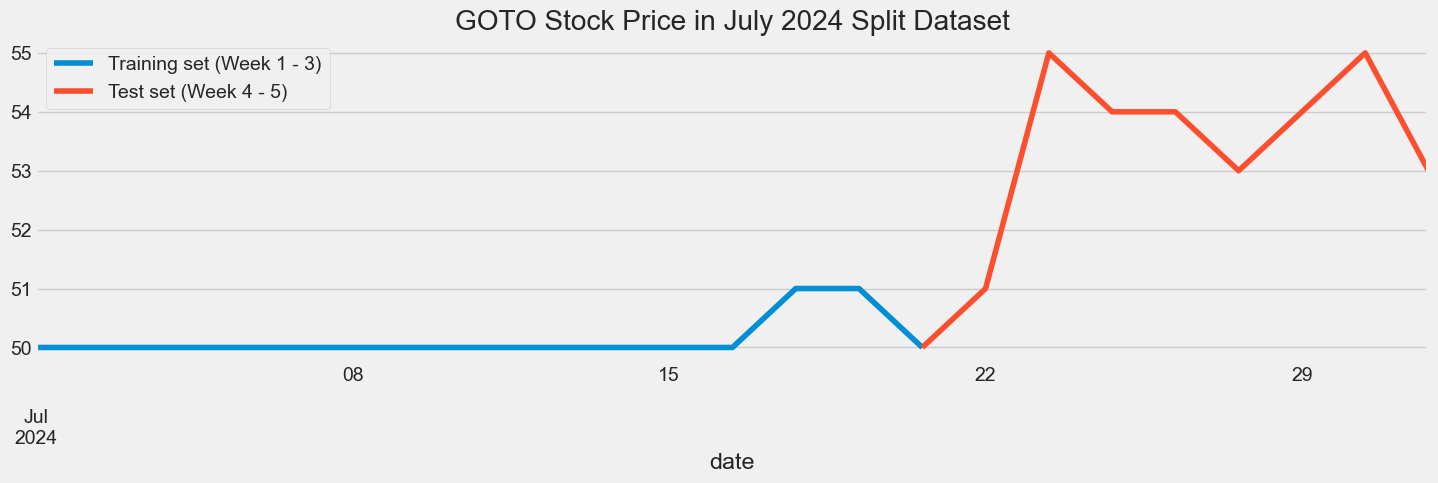

In [295]:
GOTO["close"]["2024-07-01":"2024-07-19"].plot(figsize=(16,4), legend=True)
GOTO["close"]["2024-07-19":"2024-07-31"].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Week 1 - 3)","Test set (Week 4 - 5)"])
plt.title('GOTO Stock Price in July 2024 Split Dataset')
plt.show()

In [296]:
#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(GOTO_short_train)
len_train = len(GOTO_short_train)
len_test = len(GOTO_short_test)
print(len_train, len_test)

# Since LSTMs store long term memory state, we create a data structure with 5 timesteps and 1 output
# So for each element of training set, we have 5 previous training set elements 
X_train = []
y_train = []
for i in range(5,len_train):
    X_train.append(training_set_scaled[i-5:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

dataset_total = pd.concat((GOTO["close"]["2024-07-01":"2024-07-19"],GOTO["close"]["2024-07-19":"2024-07-31"]),axis=0)
inputs = dataset_total[len(dataset_total)-len(GOTO_short_test) - 5:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

15 9


#### LSTM Predicitions

In [297]:
regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3022
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1733
Epoch 3/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1219
Epoch 4/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0989
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0759
Epoch 6/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0630
Epoch 7/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0535
Epoch 8/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0448
Epoch 9/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0361
Epoch 10/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0317
Epoch 11/50
1/1 [==============================] - 0s 39ms/step - loss: 0.0252
Epoch 12/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0221
Epoch 13/50
1/1 [==============================] - 0s 27ms/st

In [298]:
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

1/1 [==============================] - 0s 47ms/step


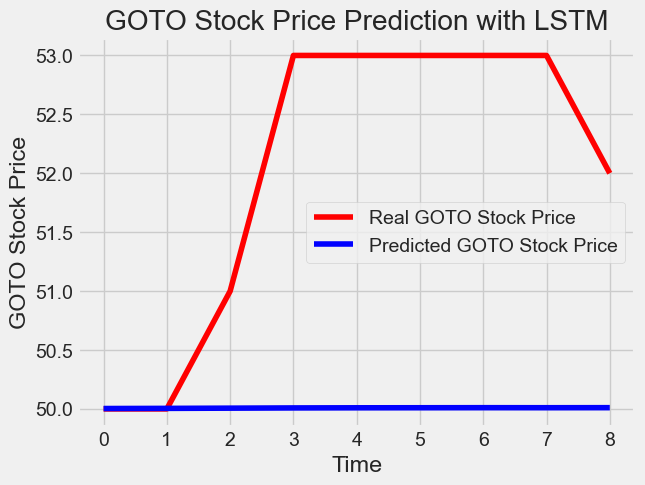

In [299]:
# Visualizing the results for LSTM
lstm_title = "with LSTM"
plot_predictions('GOTO', GOTO_short_test,LSTM_predicted_stock_price, lstm_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\3123027224.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = LSTM_predicted_stock_price


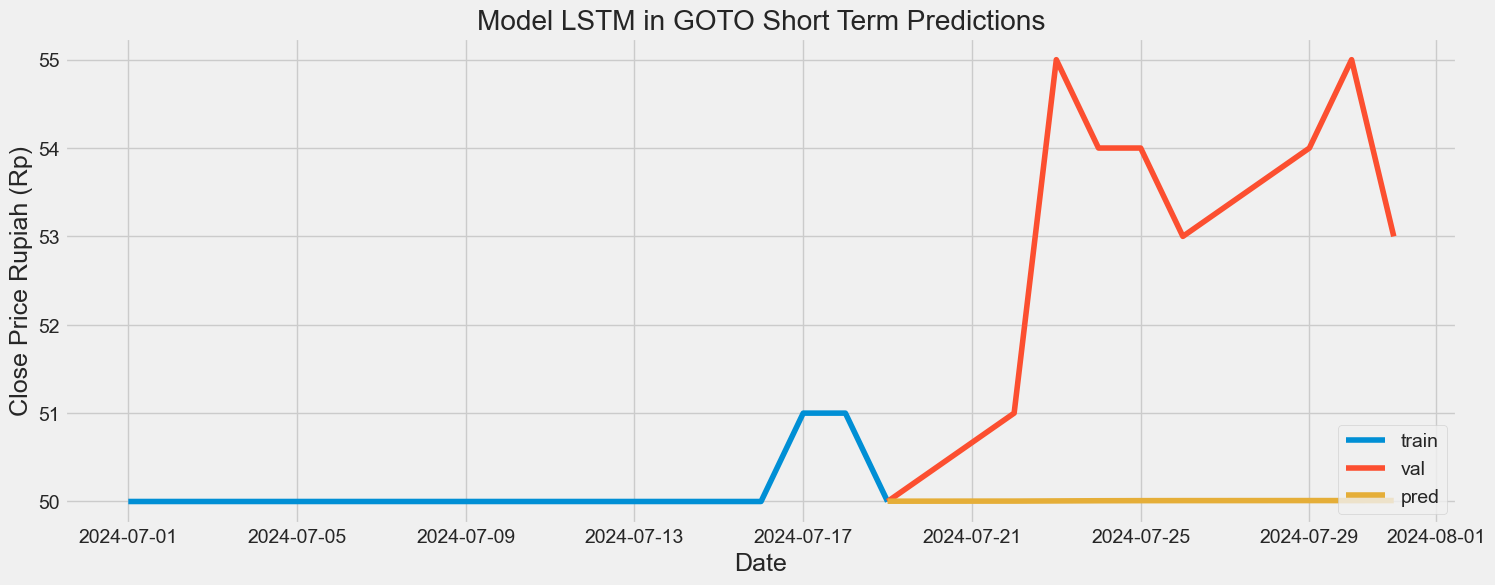

In [300]:
# Visualize the data
# Plot the data
train = GOTO["2024-07-01":"2024-07-19"]
valid = GOTO["2024-07-19":"2024-07-31"]
valid['pred'] = LSTM_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM in GOTO Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [301]:
# Evaluating the sequence
rmse = return_rmse(GOTO_short_test,LSTM_predicted_stock_price)
norm_rmse = return_rmse_norm(GOTO_short_test,LSTM_predicted_stock_price)
dic_res['stock'].append('GOTO')
dic_res['term'].append('short')
dic_res['algorithm'].append('LSTM')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 2.3488875529871756.
The root mean squared error after normalization is 0.7829625176623907.


#### GRU Predictions

In [302]:
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
1/1 [==============================] - 0s 34ms/step - loss: 0.3153
Epoch 2/50
1/1 [==============================] - 0s 61ms/step - loss: 0.2559
Epoch 3/50
1/1 [==============================] - 0s 35ms/step - loss: 0.1633
Epoch 4/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0794
Epoch 5/50
1/1 [==============================] - 0s 52ms/step - loss: 0.0342
Epoch 6/50
1/1 [==============================] - 0s 34ms/step - loss: 0.0015
Epoch 7/50
1/1 [==============================] - 0s 40ms/step - loss: 0.0062
Epoch 8/50
1/1 [==============================] - 0s 43ms/step - loss: 0.0304
Epoch 9/50
1/1 [==============================] - 0s 40ms/step - loss: 0.0666
Epoch 10/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0782
Epoch 11/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1027
Epoch 12/50
1/1 [==============================] - 0s 57ms/step - loss: 0.0963
Epoch 13/50
1/1 [==============================] - 0s 25ms/st

In [303]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

1/1 [==============================] - 0s 52ms/step


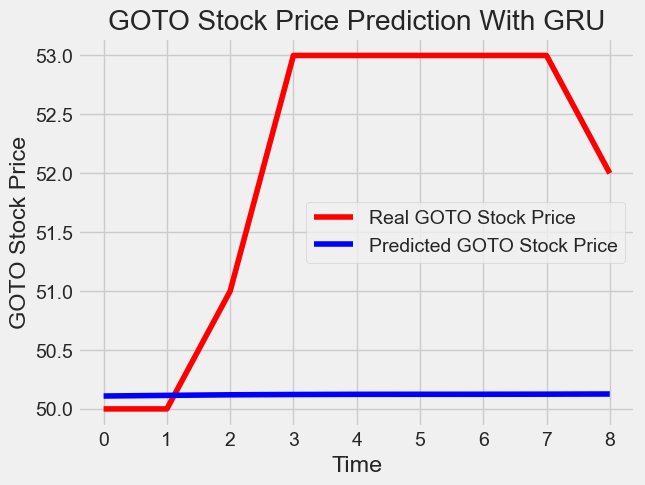

In [304]:
# Visualizing the results for GRU
gru_title = "With GRU"
plot_predictions("GOTO", GOTO_short_test,GRU_predicted_stock_price, gru_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\1326391635.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = GRU_predicted_stock_price


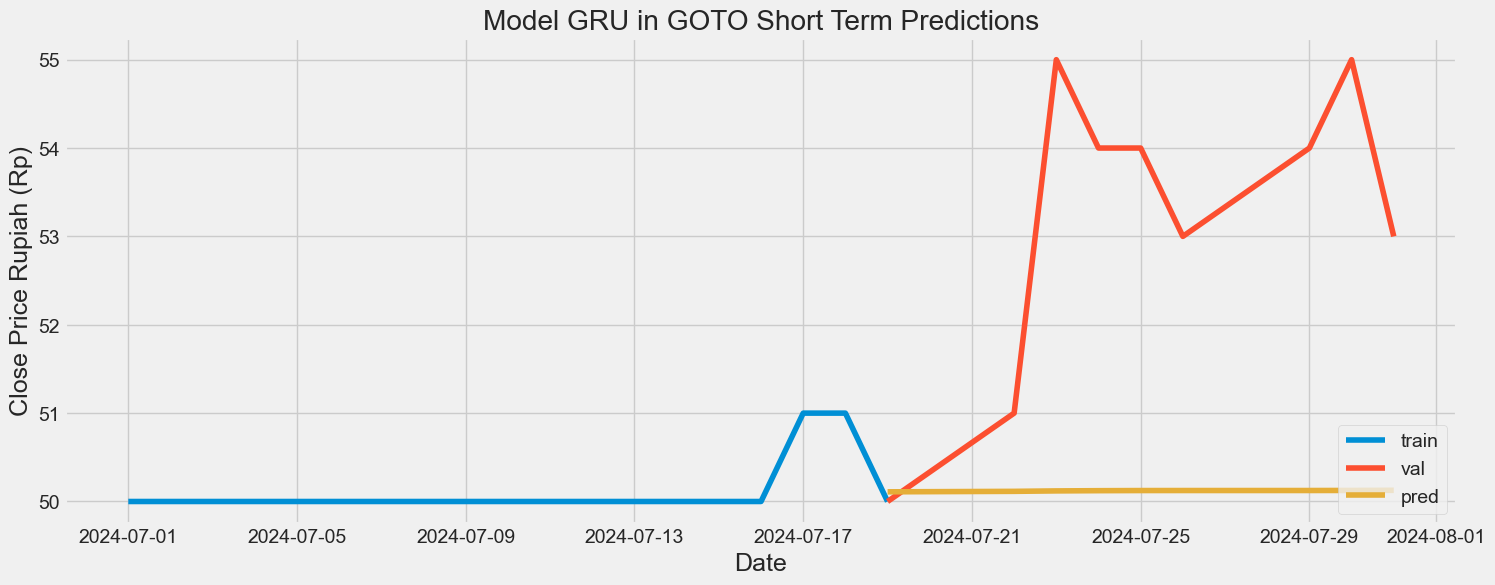

In [305]:
# Visualize the data
# Plot the data
train = GOTO["2024-07-01":"2024-07-19"]
valid = GOTO["2024-07-19":"2024-07-31"]
valid['pred'] = GRU_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model GRU in GOTO Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [306]:
# Evaluating the sequence

rmse = return_rmse(GOTO_short_test, GRU_predicted_stock_price)
norm_rmse = return_rmse_norm(GOTO_short_test, GRU_predicted_stock_price)
dic_res['stock'].append('GOTO')
dic_res['term'].append('short')
dic_res['algorithm'].append('GRU')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 2.2525881150470557.
The root mean squared error after normalization is 0.7508627050156839.


#### RNN Predictions

In [307]:
regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
1/1 [==============================] - 0s 33ms/step - loss: 0.1255 - accuracy: 0.8000
Epoch 2/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1484 - accuracy: 0.8000
Epoch 3/50
1/1 [==============================] - 0s 65ms/step - loss: 0.1451 - accuracy: 0.9000
Epoch 4/50
1/1 [==============================] - 0s 49ms/step - loss: 0.0987 - accuracy: 1.0000
Epoch 5/50
1/1 [==============================] - 0s 21ms/step - loss: 0.0579 - accuracy: 1.0000
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0393 - accuracy: 1.0000
Epoch 7/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0148 - accuracy: 1.0000
Epoch 8/50
1/1 [==============================] - 0s 21ms/step - loss: 0.0174 - accuracy: 1.0000
Epoch 9/50
1/1 [==============================] - 0s 21ms/step - loss: 0.0357 - accuracy: 1.0000
Epoch 10/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0288 - accuracy: 1.0000
Epoch 11/50
1/1 [============

In [308]:
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)

1/1 [==============================] - 0s 75ms/step


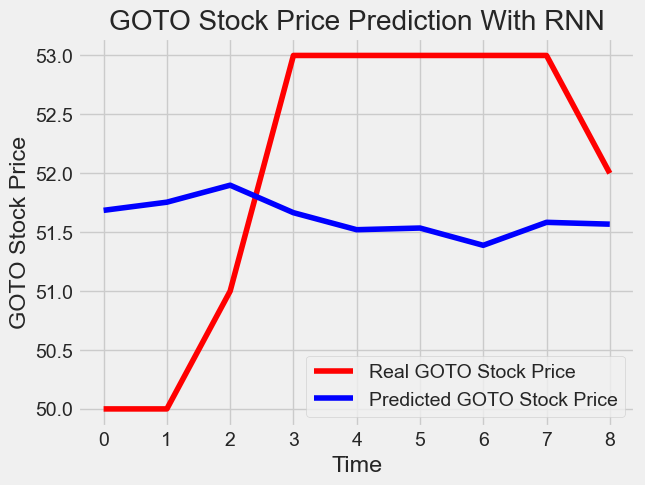

In [309]:
# Visualizing the results for RNN
rnn_title = "With RNN"
plot_predictions("GOTO", GOTO_short_test,RNN_predicted_stock_price, rnn_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\97400756.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = RNN_predicted_stock_price


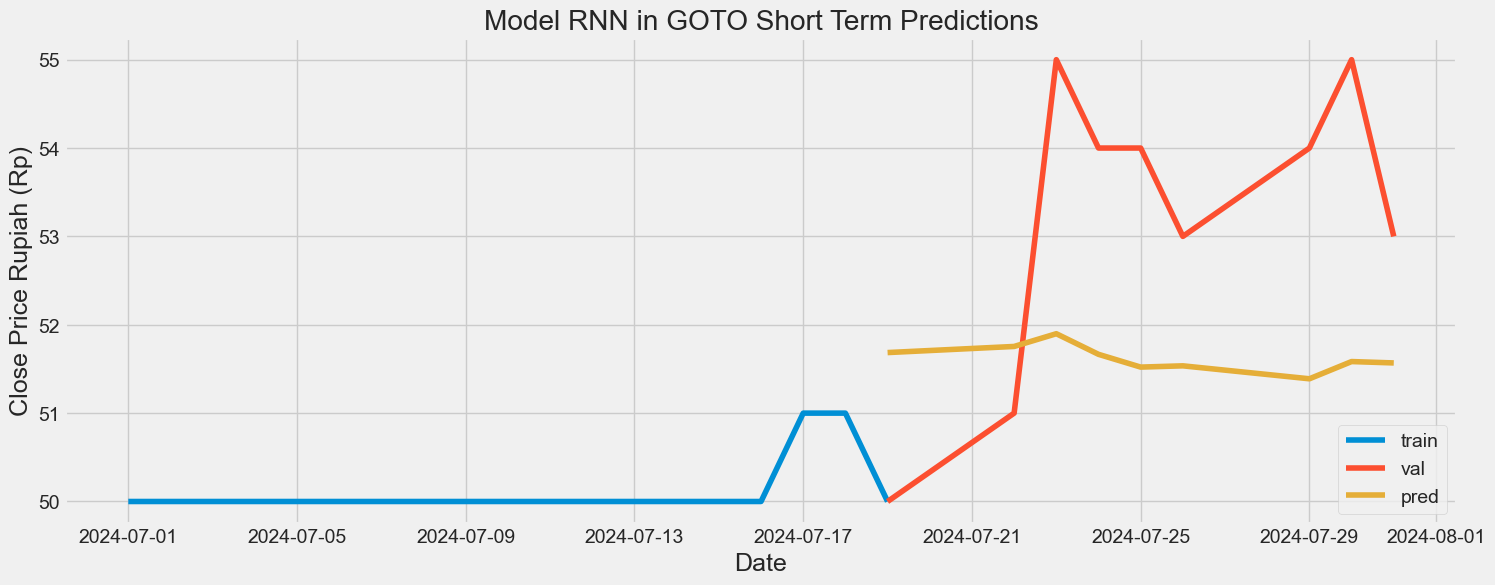

In [310]:
# Visualize the data
# Plot the data
train = GOTO["2024-07-01":"2024-07-19"]
valid = GOTO["2024-07-19":"2024-07-31"]
valid['pred'] = RNN_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model RNN in GOTO Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [311]:
# Evaluating the sequence
rmse = return_rmse(GOTO_short_test, RNN_predicted_stock_price)
norm_rmse = return_rmse_norm(GOTO_short_test, RNN_predicted_stock_price)
dic_res['stock'].append('GOTO')
dic_res['term'].append('short')
dic_res['algorithm'].append('RNN')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 1.399613424411521.
The root mean squared error after normalization is 0.46653780813717277.


### KLBF

In [313]:
KLBF.head()

stock_code  open  high   low  close    volume
date                                                    
2020-01-02       KLBF  1620  1635  1600   1615  14075700
2020-01-03       KLBF  1615  1635  1610   1635  20606000
2020-01-06       KLBF  1635  1640  1615   1640  10231400
2020-01-07       KLBF  1640  1635  1600   1635  17153100
2020-01-08       KLBF  1635  1615  1585   1585  11666700

#### Data Split

In [316]:
KLBF_short_train = KLBF["2024-07-01":"2024-07-19"].iloc[:,3:4].values
KLBF_short_test = KLBF["2024-07-19":"2024-07-31"].iloc[:,3:4].values

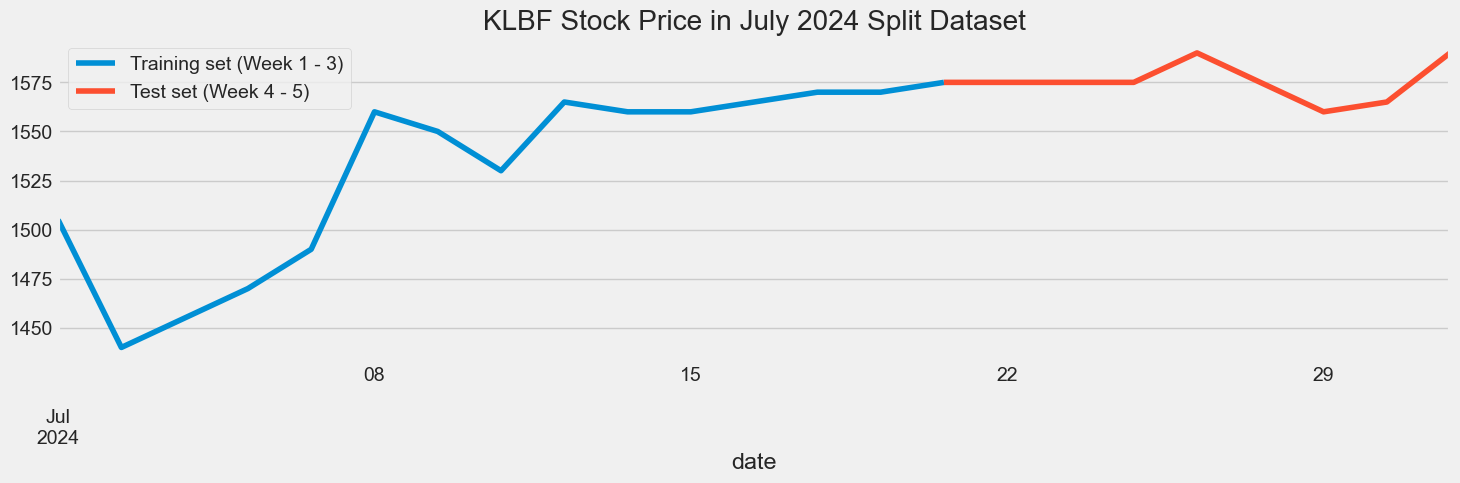

In [317]:
KLBF["close"]["2024-07-01":"2024-07-19"].plot(figsize=(16,4), legend=True)
KLBF["close"]["2024-07-19":"2024-07-31"].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Week 1 - 3)","Test set (Week 4 - 5)"])
plt.title('KLBF Stock Price in July 2024 Split Dataset')
plt.show()

In [318]:
#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(KLBF_short_train)
len_train = len(KLBF_short_train)
len_test = len(KLBF_short_test)
print(len_train, len_test)

# Since LSTMs store long term memory state, we create a data structure with 5 timesteps and 1 output
# So for each element of training set, we have 5 previous training set elements 
X_train = []
y_train = []
for i in range(5,len_train):
    X_train.append(training_set_scaled[i-5:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

dataset_total = pd.concat((KLBF["close"]["2024-07-01":"2024-07-19"],KLBF["close"]["2024-07-19":"2024-07-31"]),axis=0)
inputs = dataset_total[len(dataset_total)-len(KLBF_short_test) - 5:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

15 9


#### LSTM Predictions

In [319]:
regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
1/1 [==============================] - 0s 36ms/step - loss: 0.7619
Epoch 2/50
1/1 [==============================] - 0s 25ms/step - loss: 0.6405
Epoch 3/50
1/1 [==============================] - 0s 31ms/step - loss: 0.5678
Epoch 4/50
1/1 [==============================] - 0s 25ms/step - loss: 0.4765
Epoch 5/50
1/1 [==============================] - 0s 30ms/step - loss: 0.4139
Epoch 6/50
1/1 [==============================] - 0s 33ms/step - loss: 0.3221
Epoch 7/50
1/1 [==============================] - 0s 34ms/step - loss: 0.2402
Epoch 8/50
1/1 [==============================] - 0s 33ms/step - loss: 0.1687
Epoch 9/50
1/1 [==============================] - 0s 35ms/step - loss: 0.0891
Epoch 10/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0569
Epoch 11/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0264
Epoch 12/50
1/1 [==============================] - 0s 38ms/step - loss: 0.0252
Epoch 13/50
1/1 [==============================] - 0s 30ms/st

In [320]:
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

1/1 [==============================] - 0s 52ms/step


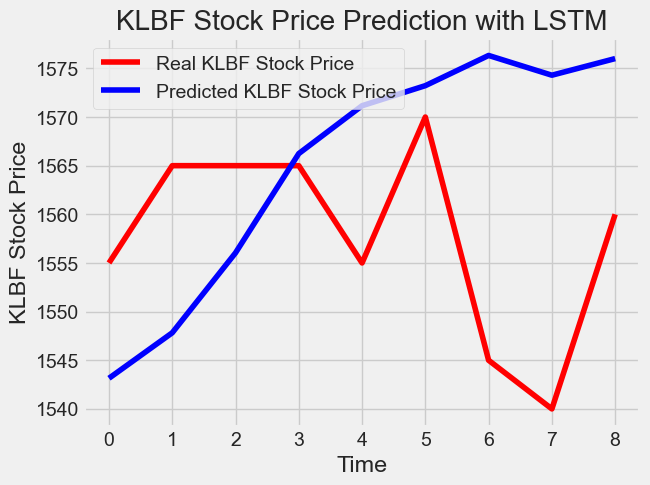

In [321]:
# Visualizing the results for LSTM
lstm_title = "with LSTM"
plot_predictions('KLBF', KLBF_short_test,LSTM_predicted_stock_price, lstm_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\340080784.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = LSTM_predicted_stock_price


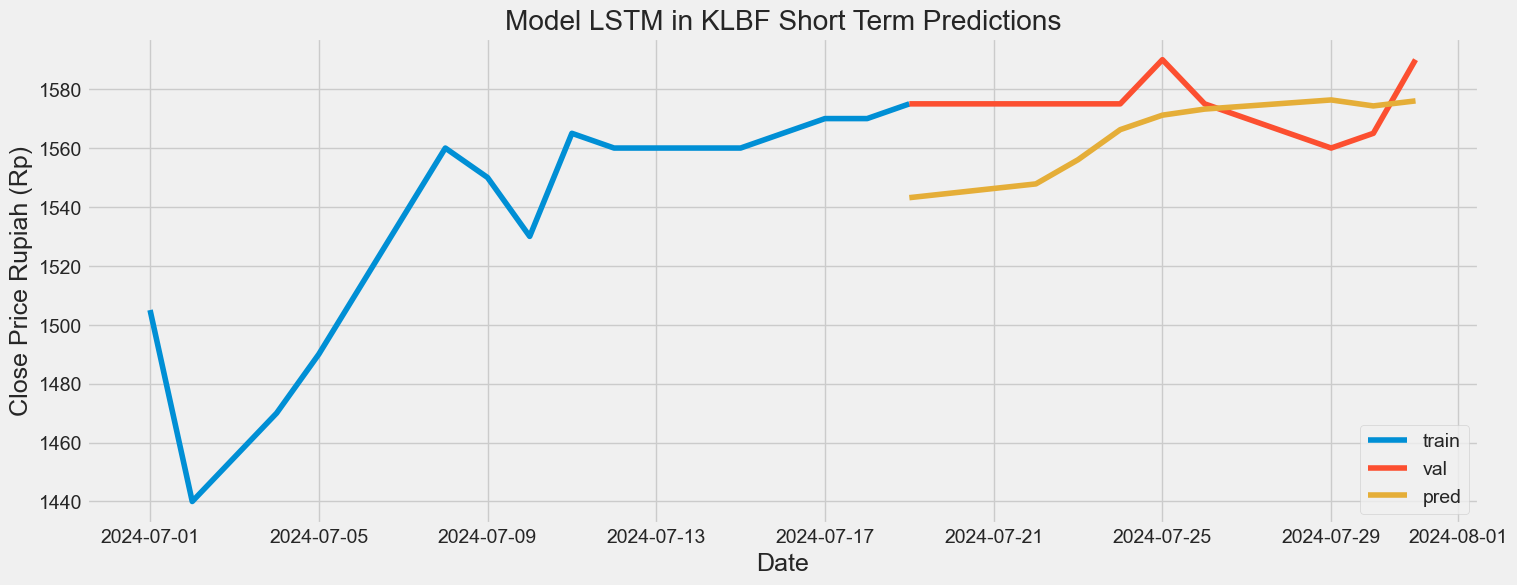

In [322]:
# Visualize the data
# Plot the data
train = KLBF["2024-07-01":"2024-07-19"]
valid = KLBF["2024-07-19":"2024-07-31"]
valid['pred'] = LSTM_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM in KLBF Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [323]:
# Evaluating the sequence
rmse = return_rmse(KLBF_short_test,LSTM_predicted_stock_price)
norm_rmse = return_rmse_norm(KLBF_short_test,LSTM_predicted_stock_price)
dic_res['stock'].append('KLBF')
dic_res['term'].append('short')
dic_res['algorithm'].append('LSTM')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 18.86463912991249.
The root mean squared error after normalization is 0.5192846900276976.


#### GRU Predictions

In [324]:
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
1/1 [==============================] - 0s 31ms/step - loss: 0.7162
Epoch 2/50
1/1 [==============================] - 0s 31ms/step - loss: 0.6304
Epoch 3/50
1/1 [==============================] - 0s 34ms/step - loss: 0.5128
Epoch 4/50
1/1 [==============================] - 0s 37ms/step - loss: 0.3637
Epoch 5/50
1/1 [==============================] - 0s 32ms/step - loss: 0.2216
Epoch 6/50
1/1 [==============================] - 0s 36ms/step - loss: 0.1005
Epoch 7/50
1/1 [==============================] - 0s 38ms/step - loss: 0.0310
Epoch 8/50
1/1 [==============================] - 0s 33ms/step - loss: 0.0167
Epoch 9/50
1/1 [==============================] - 0s 31ms/step - loss: 0.0388
Epoch 10/50
1/1 [==============================] - 0s 39ms/step - loss: 0.0950
Epoch 11/50
1/1 [==============================] - 0s 30ms/step - loss: 0.1132
Epoch 12/50
1/1 [==============================] - 0s 37ms/step - loss: 0.1728
Epoch 13/50
1/1 [==============================] - 0s 29ms/st

In [325]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

1/1 [==============================] - 0s 51ms/step


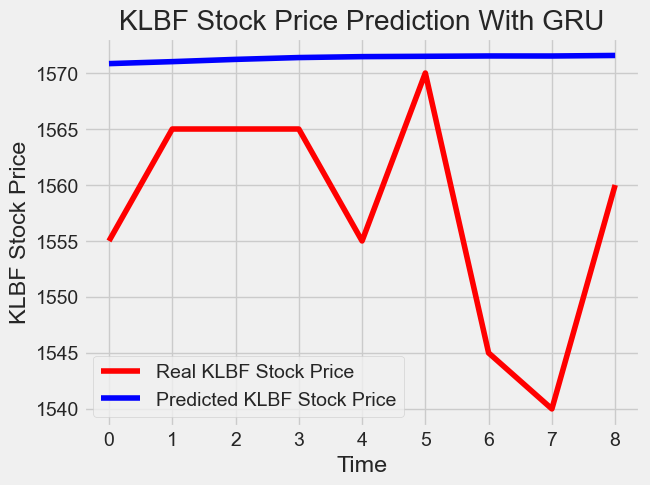

In [327]:
# Visualizing the results for GRU
gru_title = "With GRU"
plot_predictions("KLBF", KLBF_short_test,GRU_predicted_stock_price, gru_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\2049848409.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = GRU_predicted_stock_price


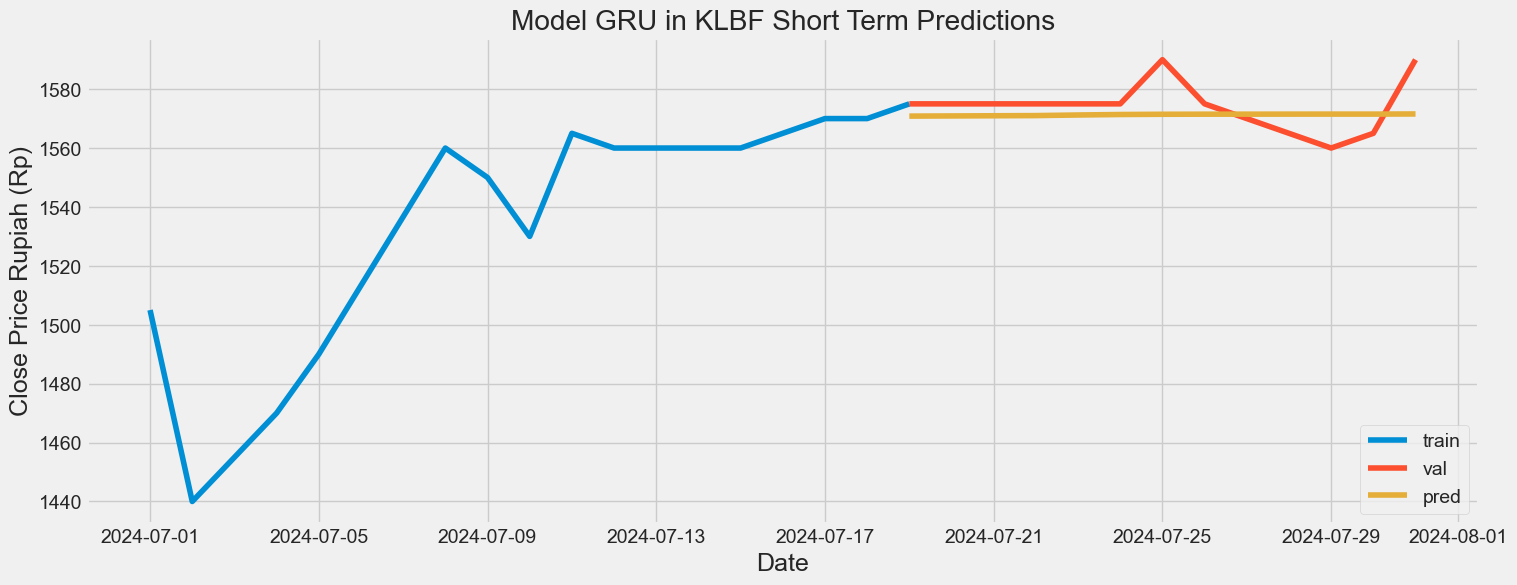

In [328]:
# Visualize the data
# Plot the data
train = KLBF["2024-07-01":"2024-07-19"]
valid = KLBF["2024-07-19":"2024-07-31"]
valid['pred'] = GRU_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model GRU in KLBF Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [329]:
# Evaluating the sequence

rmse = return_rmse(KLBF_short_test, GRU_predicted_stock_price)
norm_rmse = return_rmse_norm(KLBF_short_test, GRU_predicted_stock_price)
dic_res['stock'].append('KLBF')
dic_res['term'].append('short')
dic_res['algorithm'].append('GRU')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 16.568604397298863.
The root mean squared error after normalization is 0.524832211551769.


#### RNN Predictions

In [330]:
regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
1/1 [==============================] - 0s 32ms/step - loss: 0.3328 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 17ms/step - loss: 0.1531 - accuracy: 0.1000
Epoch 3/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2379 - accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 0.2848 - accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 16ms/step - loss: 0.1812 - accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1051 - accuracy: 0.1000
Epoch 7/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0782 - accuracy: 0.1000
Epoch 8/50
1/1 [==============================] - 0s 19ms/step - loss: 0.0817 - accuracy: 0.1000
Epoch 9/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0845 - accuracy: 0.1000
Epoch 10/50
1/1 [==============================] - 0s 15ms/step - loss: 0.1346 - accuracy: 0.1000
Epoch 11/50
1/

In [331]:
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)

1/1 [==============================] - 0s 52ms/step


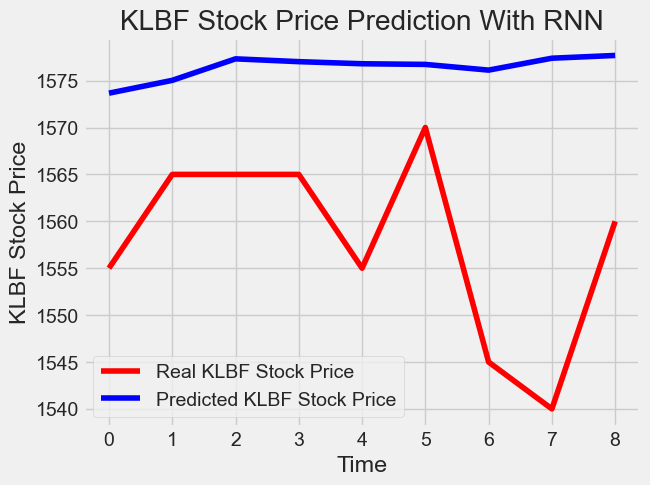

In [332]:
# Visualizing the results for RNN
rnn_title = "With RNN"
plot_predictions("KLBF", KLBF_short_test,RNN_predicted_stock_price, rnn_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\3189707113.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = RNN_predicted_stock_price


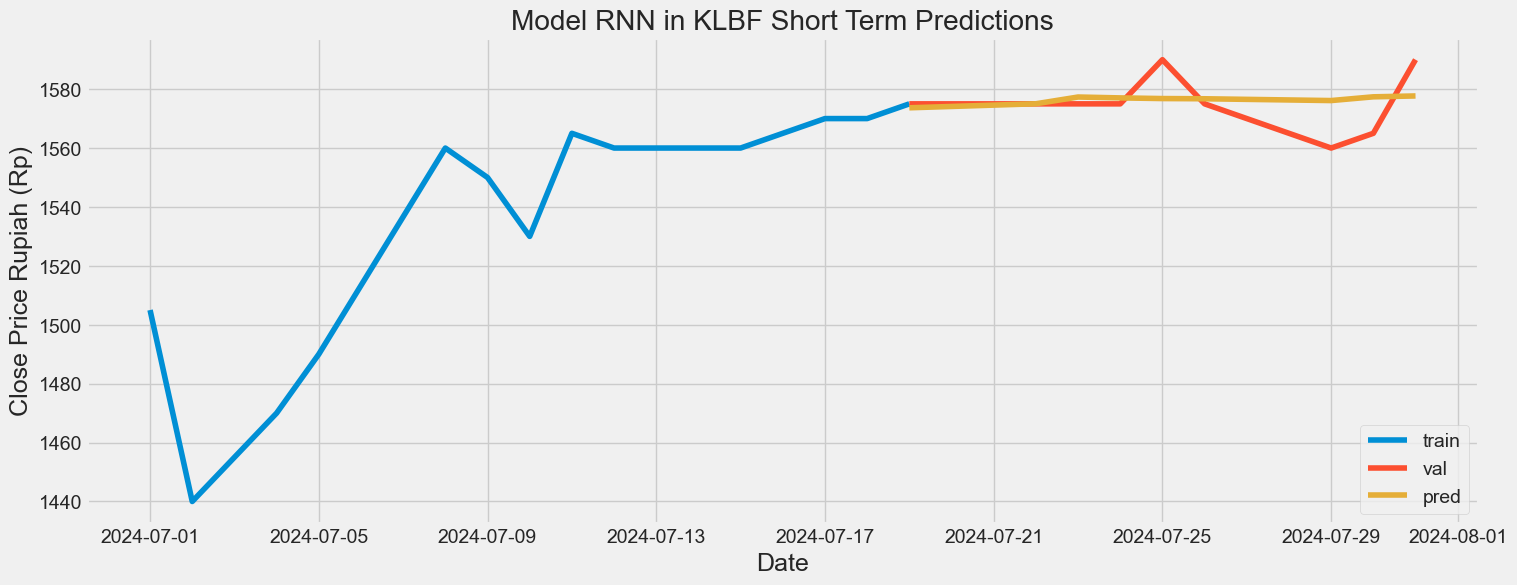

In [334]:
# Visualize the data
# Plot the data
train = KLBF["2024-07-01":"2024-07-19"]
valid = KLBF["2024-07-19":"2024-07-31"]
valid['pred'] = RNN_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model RNN in KLBF Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [335]:
# Evaluating the sequence
rmse = return_rmse(KLBF_short_test, RNN_predicted_stock_price)
norm_rmse = return_rmse_norm(KLBF_short_test, RNN_predicted_stock_price)
dic_res['stock'].append('KLBF')
dic_res['term'].append('short')
dic_res['algorithm'].append('RNN')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 20.93553479672331.
The root mean squared error after normalization is 0.5555771912559561.


### MAPI

In [314]:
MAPI.head()

stock_code  open  high   low  close    volume
date                                                    
2020-01-02       MAPI  1055  1070  1035   1065   8012800
2020-01-03       MAPI  1065  1070  1050   1070   6591500
2020-01-06       MAPI  1070  1070  1040   1055   5459500
2020-01-07       MAPI  1055  1065  1045   1055   5688100
2020-01-08       MAPI  1055  1060  1030   1035  11561800

#### Data Split

In [336]:
MAPI_short_train = MAPI["2024-07-01":"2024-07-19"].iloc[:,3:4].values
MAPI_short_test = MAPI["2024-07-19":"2024-07-31"].iloc[:,3:4].values

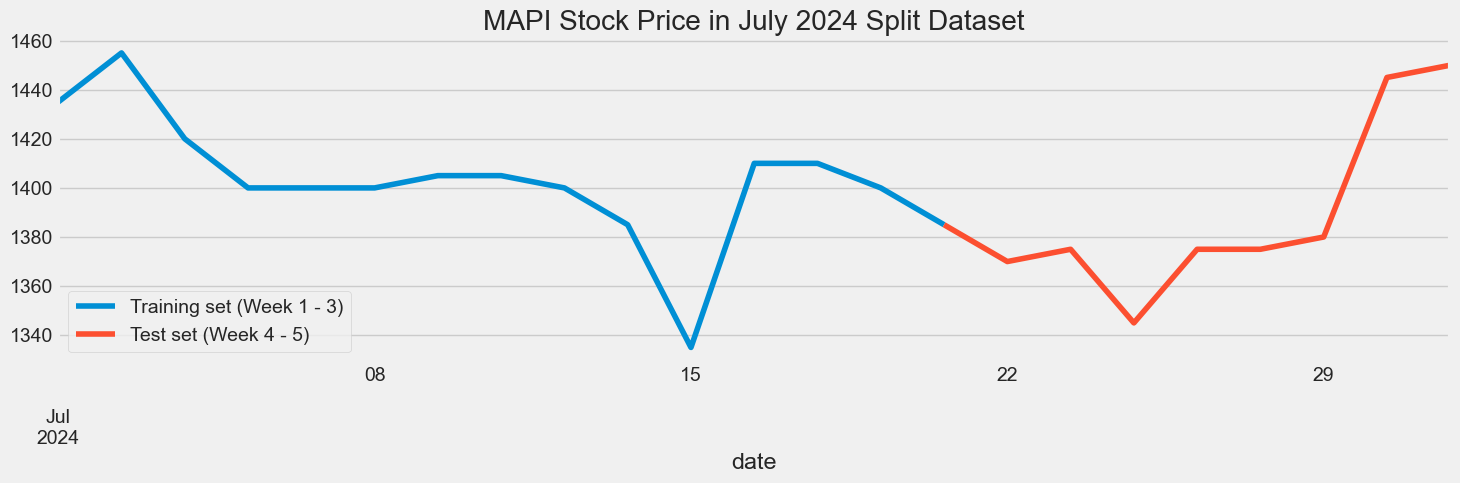

In [337]:
MAPI["close"]["2024-07-01":"2024-07-19"].plot(figsize=(16,4), legend=True)
MAPI["close"]["2024-07-19":"2024-07-31"].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Week 1 - 3)","Test set (Week 4 - 5)"])
plt.title('MAPI Stock Price in July 2024 Split Dataset')
plt.show()

In [338]:
#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(MAPI_short_train)
len_train = len(MAPI_short_train)
len_test = len(MAPI_short_test)
print(len_train, len_test)

# Since LSTMs store long term memory state, we create a data structure with 5 timesteps and 1 output
# So for each element of training set, we have 5 previous training set elements 
X_train = []
y_train = []
for i in range(5,len_train):
    X_train.append(training_set_scaled[i-5:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

dataset_total = pd.concat((MAPI["close"]["2024-07-01":"2024-07-19"],MAPI["close"]["2024-07-19":"2024-07-31"]),axis=0)
inputs = dataset_total[len(dataset_total)-len(MAPI_short_test) - 5:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

15 9


#### LSTM Predictions

In [339]:
regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

Epoch 1/50
1/1 [==============================] - 0s 35ms/step - loss: 0.2464
Epoch 2/50
1/1 [==============================] - 0s 34ms/step - loss: 0.0936
Epoch 3/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0765
Epoch 4/50
1/1 [==============================] - 0s 35ms/step - loss: 0.0553
Epoch 5/50
1/1 [==============================] - 0s 40ms/step - loss: 0.0659
Epoch 6/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0636
Epoch 7/50
1/1 [==============================] - 0s 34ms/step - loss: 0.0596
Epoch 8/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0590
Epoch 9/50
1/1 [==============================] - 0s 31ms/step - loss: 0.0522
Epoch 10/50
1/1 [==============================] - 0s 33ms/step - loss: 0.0542
Epoch 11/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0563
Epoch 12/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0549
Epoch 13/50
1/1 [==============================] - 0s 60ms/st

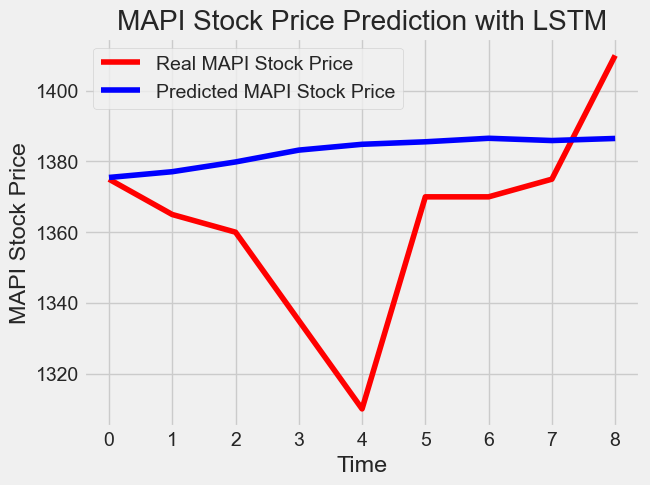

In [341]:
# Visualizing the results for LSTM
lstm_title = "with LSTM"
plot_predictions('MAPI', MAPI_short_test,LSTM_predicted_stock_price, lstm_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\3767520715.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = LSTM_predicted_stock_price


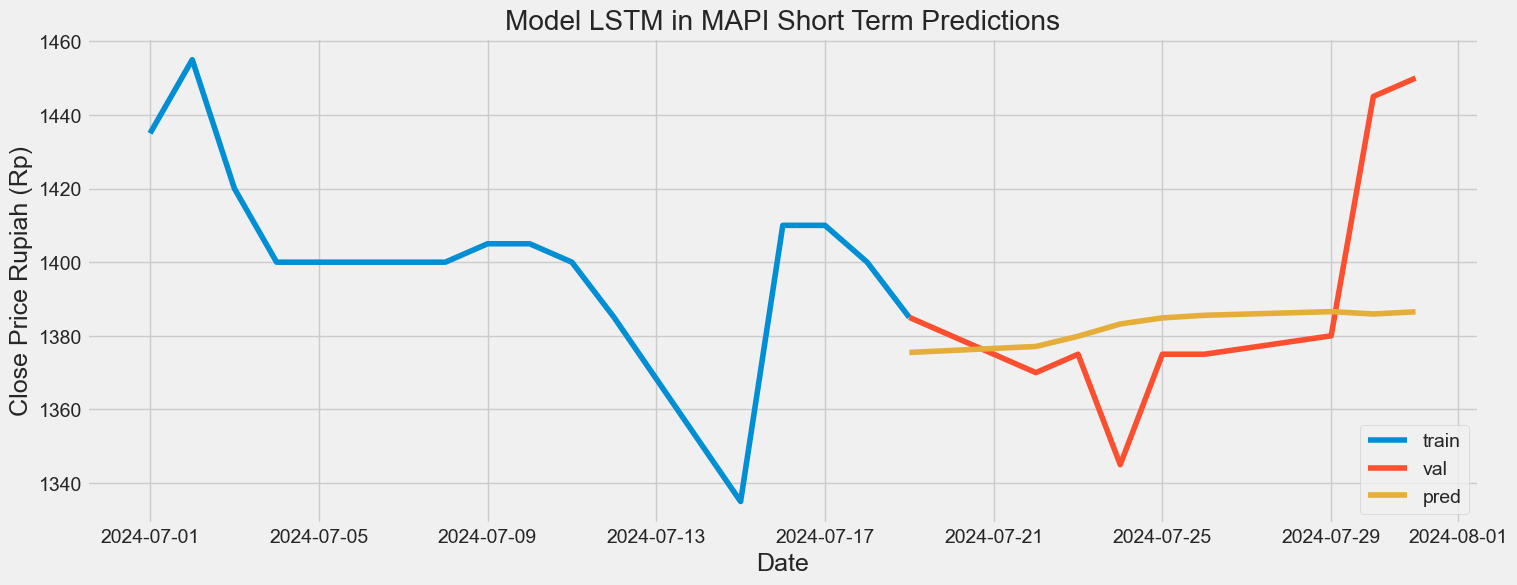

In [343]:
# Visualize the data
# Plot the data
train = MAPI["2024-07-01":"2024-07-19"]
valid = MAPI["2024-07-19":"2024-07-31"]
valid['pred'] = LSTM_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM in MAPI Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [344]:
# Evaluating the sequence
rmse = return_rmse(MAPI_short_test,LSTM_predicted_stock_price)
norm_rmse = return_rmse_norm(MAPI_short_test,LSTM_predicted_stock_price)
dic_res['stock'].append('MAPI')
dic_res['term'].append('short')
dic_res['algorithm'].append('LSTM')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 32.76096880783074.
The root mean squared error after normalization is 0.32760968807830776.


#### GRU Predictions

In [345]:
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

Epoch 1/50
1/1 [==============================] - 0s 34ms/step - loss: 0.2422
Epoch 2/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2202
Epoch 3/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1828
Epoch 4/50
1/1 [==============================] - 0s 21ms/step - loss: 0.1403
Epoch 5/50
1/1 [==============================] - 0s 34ms/step - loss: 0.1069
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0984
Epoch 7/50
1/1 [==============================] - 0s 21ms/step - loss: 0.0683
Epoch 8/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0604
Epoch 9/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0549
Epoch 10/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0638
Epoch 11/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0639
Epoch 12/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0685
Epoch 13/50
1/1 [==============================] - 0s 25ms/st

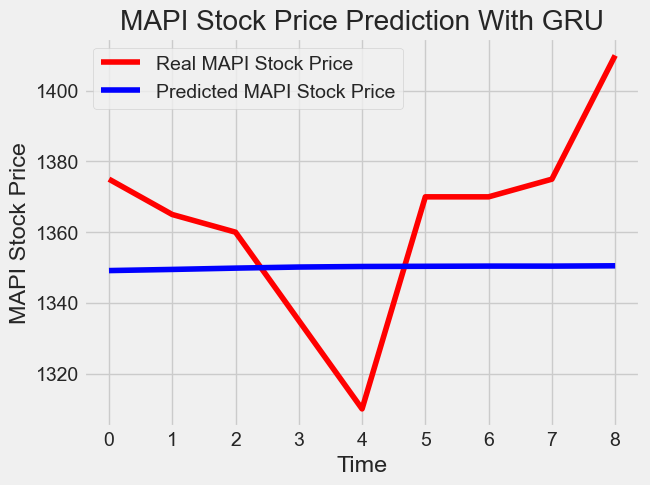

In [346]:
# Visualizing the results for GRU
gru_title = "With GRU"
plot_predictions("MAPI", MAPI_short_test,GRU_predicted_stock_price, gru_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\1285455158.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = GRU_predicted_stock_price


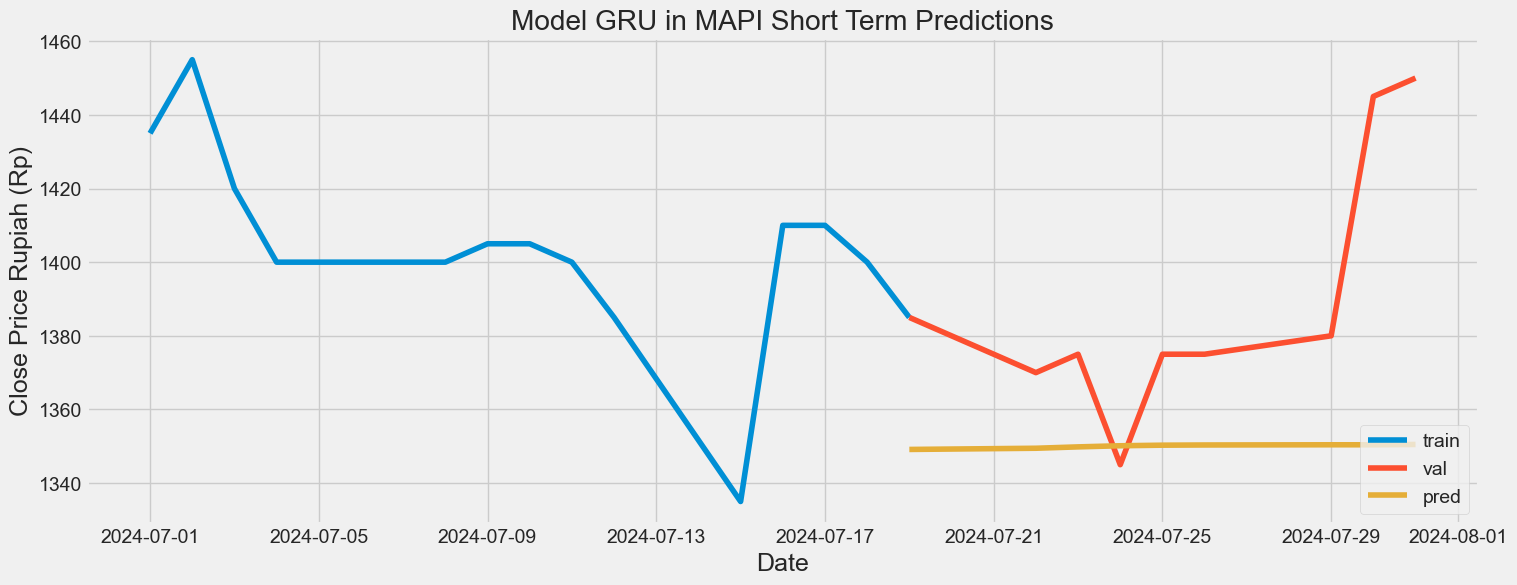

In [347]:
# Visualize the data
# Plot the data
train = MAPI["2024-07-01":"2024-07-19"]
valid = MAPI["2024-07-19":"2024-07-31"]
valid['pred'] = GRU_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model GRU in MAPI Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [348]:
# Evaluating the sequence

rmse = return_rmse(MAPI_short_test, GRU_predicted_stock_price)
norm_rmse = return_rmse_norm(MAPI_short_test, GRU_predicted_stock_price)
dic_res['stock'].append('MAPI')
dic_res['term'].append('short')
dic_res['algorithm'].append('GRU')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 29.407887567702762.
The root mean squared error after normalization is 0.29407887567702773.


#### RNN Predictions

In [349]:
regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)

Epoch 1/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2730 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 19ms/step - loss: 0.2061 - accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0764 - accuracy: 0.2000
Epoch 4/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1055 - accuracy: 0.1000
Epoch 5/50
1/1 [==============================] - 0s 20ms/step - loss: 0.1394 - accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1520 - accuracy: 0.2000
Epoch 7/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0973 - accuracy: 0.2000
Epoch 8/50
1/1 [==============================] - 0s 17ms/step - loss: 0.1075 - accuracy: 0.2000
Epoch 9/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1915 - accuracy: 0.2000
Epoch 10/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0449 - accuracy: 0.2000
Epoch 11/50
1/1 [

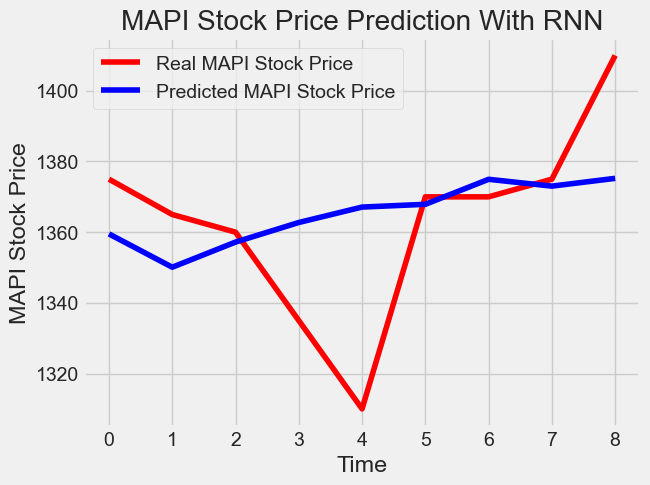

In [350]:
# Visualizing the results for RNN
rnn_title = "With RNN"
plot_predictions("MAPI", MAPI_short_test,RNN_predicted_stock_price, rnn_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\3191121687.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = RNN_predicted_stock_price


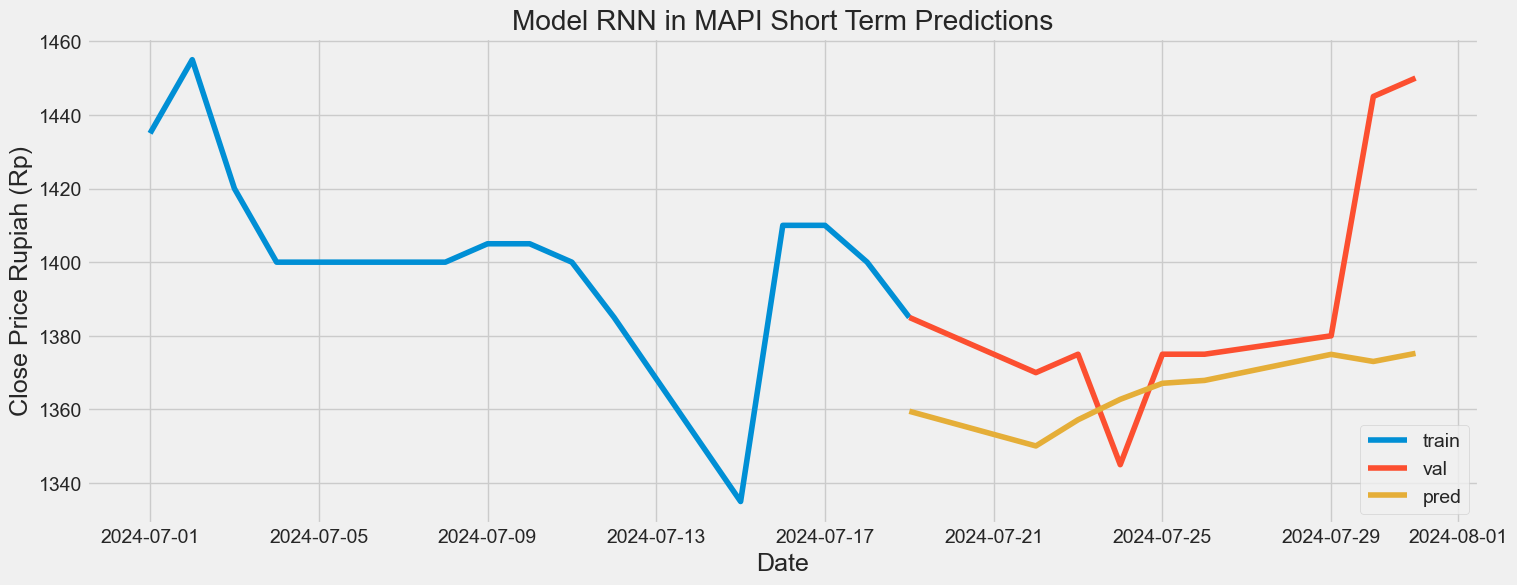

In [351]:
# Visualize the data
# Plot the data
train = MAPI["2024-07-01":"2024-07-19"]
valid = MAPI["2024-07-19":"2024-07-31"]
valid['pred'] = RNN_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model RNN in MAPI Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [352]:
# Evaluating the sequence
rmse = return_rmse(MAPI_short_test, RNN_predicted_stock_price)
norm_rmse = return_rmse_norm(MAPI_short_test, RNN_predicted_stock_price)
dic_res['stock'].append('MAPI')
dic_res['term'].append('short')
dic_res['algorithm'].append('RNN')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 25.26078882972303.
The root mean squared error after normalization is 0.2526078882972301.


### TLKM

In [315]:
TLKM.head()

stock_code  open  high   low  close    volume
date                                                    
2020-01-02       TLKM  3970  4000  3900   3910  52094000
2020-01-03       TLKM  3910  3980  3930   3980  70032900
2020-01-06       TLKM  3980  3970  3930   3960  42908900
2020-01-07       TLKM  3960  3970  3920   3940  51837600
2020-01-08       TLKM  3940  3950  3900   3900  52402600

#### Data Split

In [353]:
TLKM_short_train = TLKM["2024-07-01":"2024-07-19"].iloc[:,3:4].values
TLKM_short_test = TLKM["2024-07-19":"2024-07-31"].iloc[:,3:4].values

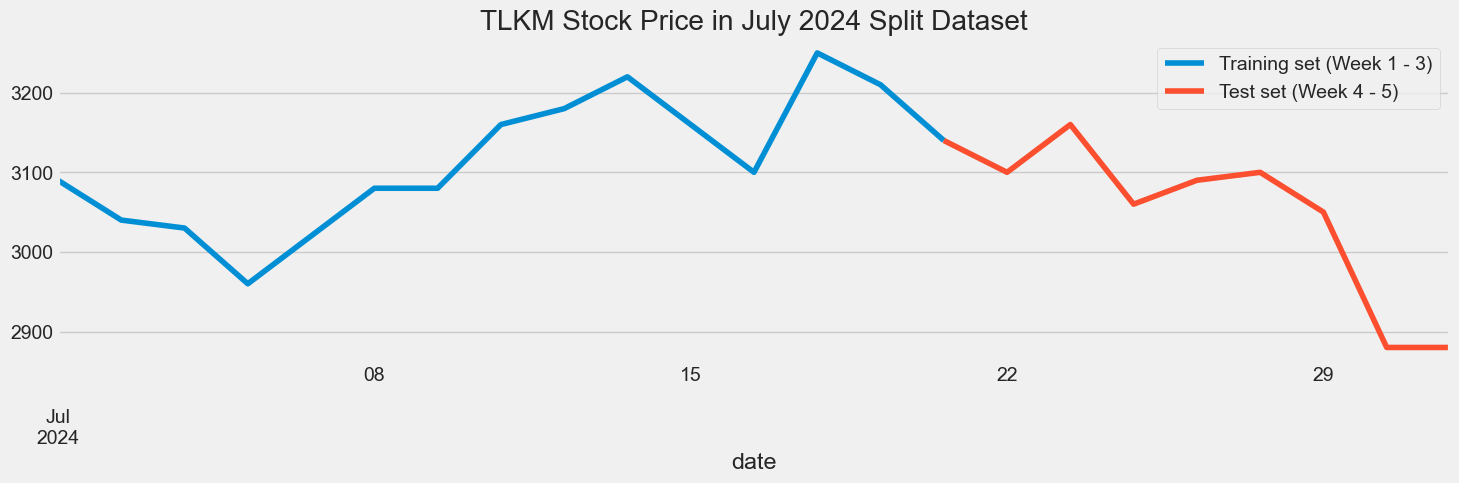

In [354]:
TLKM["close"]["2024-07-01":"2024-07-19"].plot(figsize=(16,4), legend=True)
TLKM["close"]["2024-07-19":"2024-07-31"].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Week 1 - 3)","Test set (Week 4 - 5)"])
plt.title('TLKM Stock Price in July 2024 Split Dataset')
plt.show()

In [355]:
#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(TLKM_short_train)
len_train = len(TLKM_short_train)
len_test = len(TLKM_short_test)
print(len_train, len_test)

# Since LSTMs store long term memory state, we create a data structure with 5 timesteps and 1 output
# So for each element of training set, we have 5 previous training set elements 
X_train = []
y_train = []
for i in range(5,len_train):
    X_train.append(training_set_scaled[i-5:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

dataset_total = pd.concat((TLKM["close"]["2024-07-01":"2024-07-19"],TLKM["close"]["2024-07-19":"2024-07-31"]),axis=0)
inputs = dataset_total[len(dataset_total)-len(TLKM_short_test) - 5:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

15 9


#### LSTM Predictions

In [357]:
regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

Epoch 1/50
1/1 [==============================] - 0s 37ms/step - loss: 0.1360
Epoch 2/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0658
Epoch 3/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0461
Epoch 4/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0517
Epoch 5/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0530
Epoch 6/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0606
Epoch 7/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0479
Epoch 8/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0572
Epoch 9/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0560
Epoch 10/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0600
Epoch 11/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0594
Epoch 12/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0589
Epoch 13/50
1/1 [==============================] - 0s 27ms/st

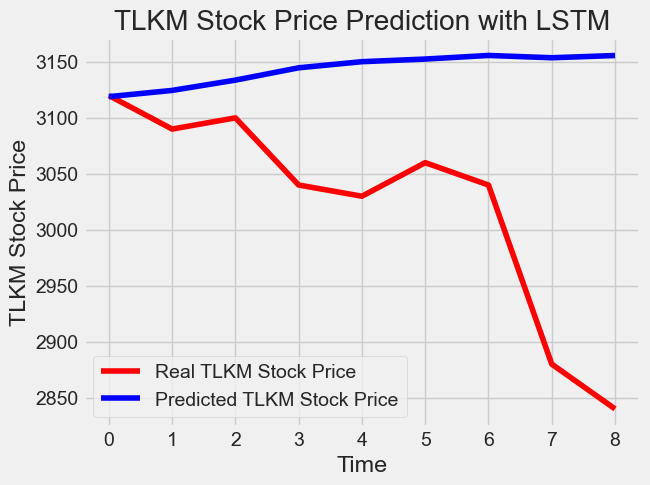

In [358]:
# Visualizing the results for LSTM
lstm_title = "with LSTM"
plot_predictions('TLKM', TLKM_short_test,LSTM_predicted_stock_price, lstm_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\3926882567.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = LSTM_predicted_stock_price


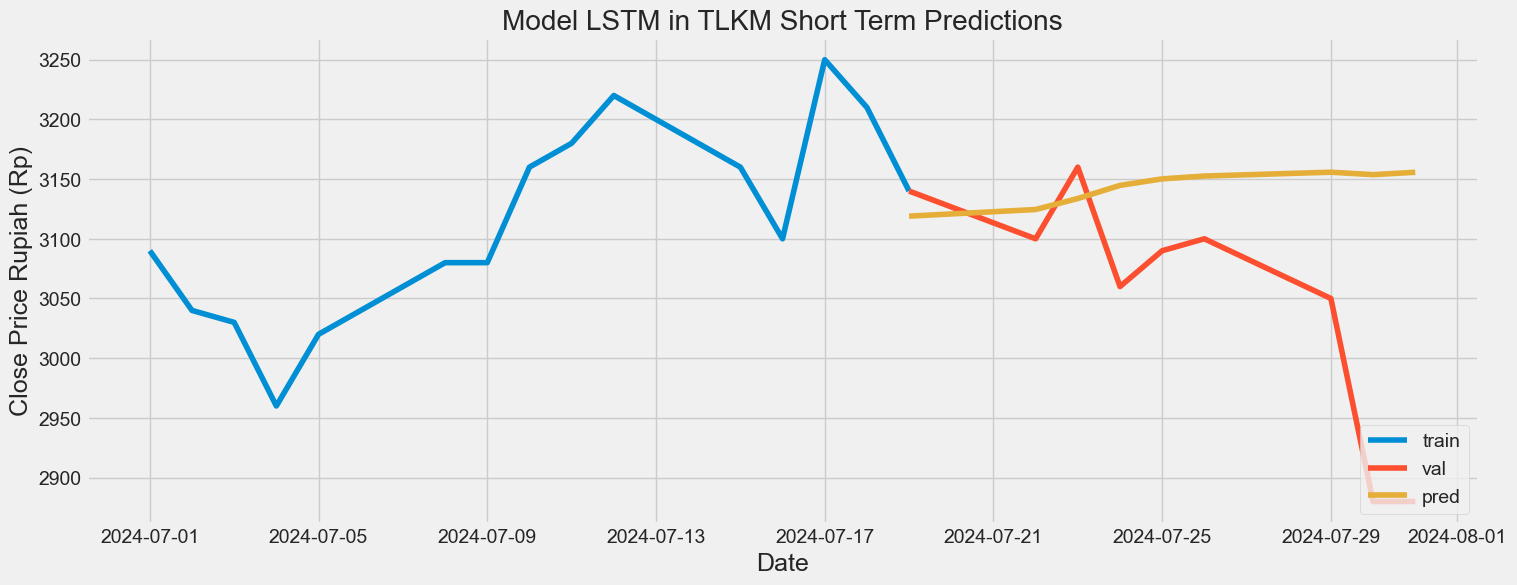

In [359]:
# Visualize the data
# Plot the data
train = TLKM["2024-07-01":"2024-07-19"]
valid = TLKM["2024-07-19":"2024-07-31"]
valid['pred'] = LSTM_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM in TLKM Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [362]:
# Evaluating the sequence
rmse = return_rmse(TLKM_short_test,LSTM_predicted_stock_price)
norm_rmse = return_rmse_norm(TLKM_short_test,LSTM_predicted_stock_price)
dic_res['stock'].append('TLKM')
dic_res['term'].append('short')
dic_res['algorithm'].append('LSTM')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 157.86431511416.
The root mean squared error after normalization is 0.4999561094683672.


#### GRU Predictions

In [363]:
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

Epoch 1/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1210
Epoch 2/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1181
Epoch 3/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1089
Epoch 4/50
1/1 [==============================] - 0s 33ms/step - loss: 0.0958
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0874
Epoch 6/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0810
Epoch 7/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0739
Epoch 8/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0745
Epoch 9/50
1/1 [==============================] - 0s 34ms/step - loss: 0.0660
Epoch 10/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0647
Epoch 11/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0601
Epoch 12/50
1/1 [==============================] - 0s 31ms/step - loss: 0.0634
Epoch 13/50
1/1 [==============================] - 0s 26ms/st

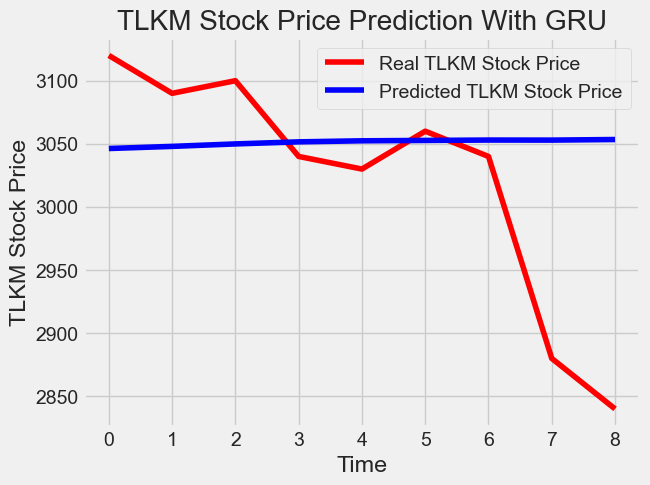

In [364]:
# Visualizing the results for GRU
gru_title = "With GRU"
plot_predictions("TLKM", TLKM_short_test,GRU_predicted_stock_price, gru_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\2924717384.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = GRU_predicted_stock_price


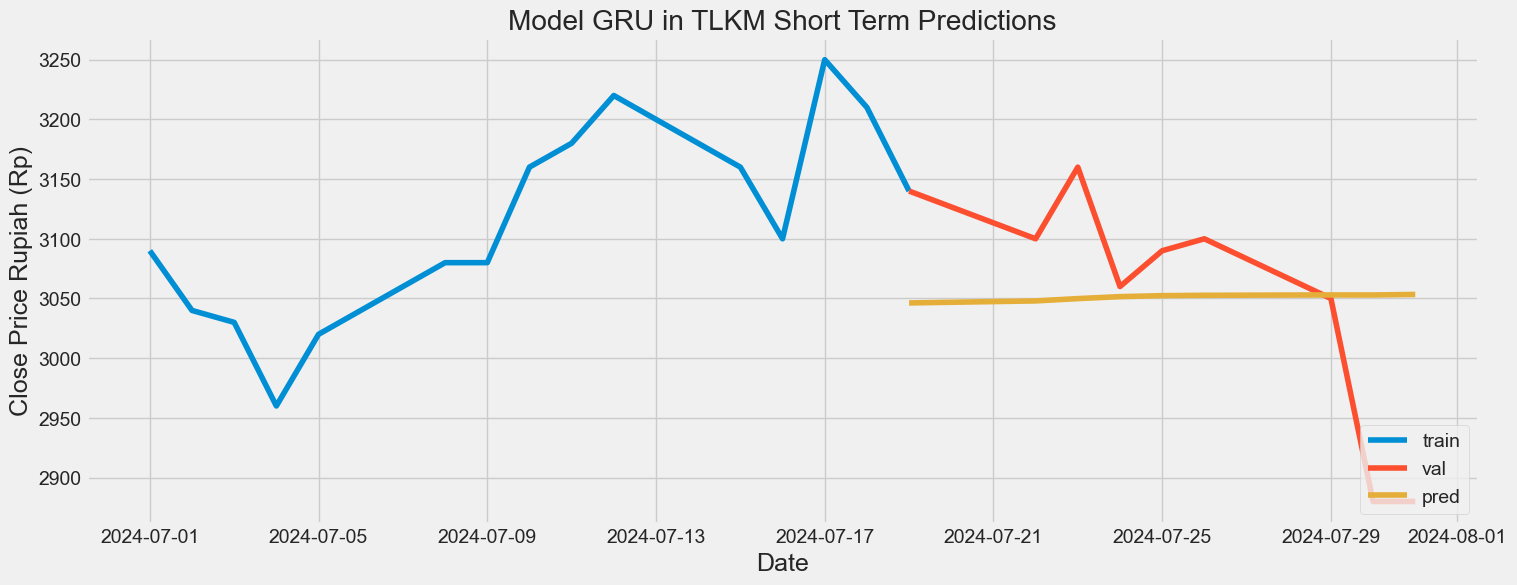

In [365]:
# Visualize the data
# Plot the data
train = TLKM["2024-07-01":"2024-07-19"]
valid = TLKM["2024-07-19":"2024-07-31"]
valid['pred'] = GRU_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model GRU in TLKM Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [366]:
# Evaluating the sequence

rmse = return_rmse(TLKM_short_test, GRU_predicted_stock_price)
norm_rmse = return_rmse_norm(TLKM_short_test, GRU_predicted_stock_price)
dic_res['stock'].append('TLKM')
dic_res['term'].append('short')
dic_res['algorithm'].append('GRU')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 97.7628496395026.
The root mean squared error after normalization is 0.34915303442679524.


#### RNN Predictions

In [367]:
regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)

Epoch 1/50
1/1 [==============================] - 0s 18ms/step - loss: 0.1515 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 18ms/step - loss: 0.1056 - accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 15ms/step - loss: 0.1474 - accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 18ms/step - loss: 0.1201 - accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 15ms/step - loss: 0.1128 - accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 19ms/step - loss: 0.1333 - accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 15ms/step - loss: 0.1200 - accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 18ms/step - loss: 0.1145 - accuracy: 0.1000
Epoch 9/50
1/1 [==============================] - 0s 16ms/step - loss: 0.0922 - accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 64ms/step - loss: 0.0892 - accuracy: 0.00

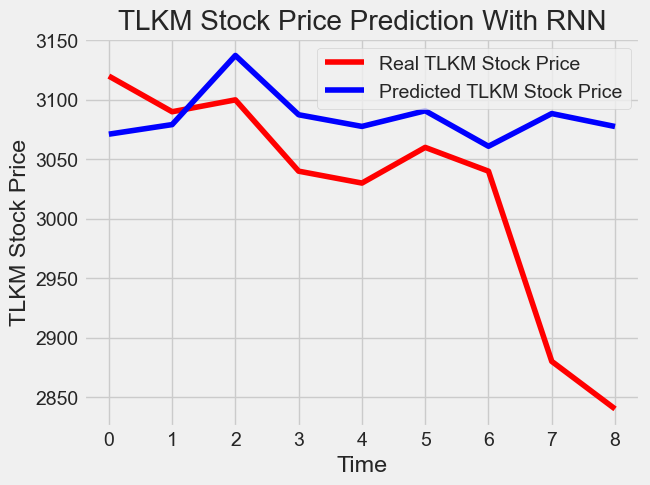

In [369]:
plot_predictions("TLKM", TLKM_short_test,RNN_predicted_stock_price, rnn_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\547812793.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = RNN_predicted_stock_price


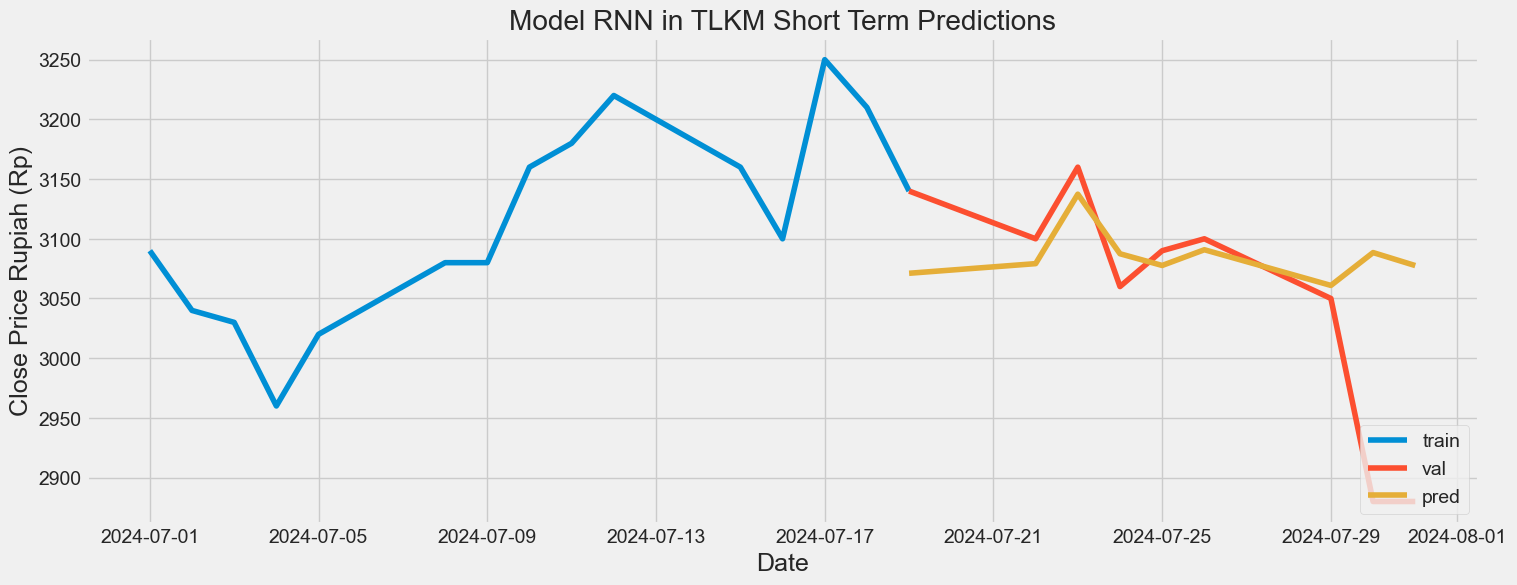

In [371]:
# Visualize the data
# Plot the data
train = TLKM["2024-07-01":"2024-07-19"]
valid = TLKM["2024-07-19":"2024-07-31"]
valid['pred'] = RNN_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model RNN in TLKM Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [372]:
# Evaluating the sequence
rmse = return_rmse(TLKM_short_test, RNN_predicted_stock_price)
norm_rmse = return_rmse_norm(TLKM_short_test, RNN_predicted_stock_price)
dic_res['stock'].append('TLKM')
dic_res['term'].append('short')
dic_res['algorithm'].append('RNN')
dic_res['rmse'].append(rmse)
dic_res['rmse_norm'].append(norm_rmse)

The root mean squared error is 110.40964294088737.
The root mean squared error after normalization is 0.3713055423388932.


### BBCA

#### Data Split

#### LSTM Predictions

#### GRU Predictions

#### RNN Predictions

## Medium Term Predictions
Medium term prediction using in this program is prediction of the several month in a year.
Data use for this predictions is data in year 2023 because that is the complete one.
Data train and test is:
1. Data Train
    * Month 1 - 9: January - September 2023
2. Data Test
    * Month 10 - 13: Oktober - Desember 2023

### ADRO

#### Data Split

In [117]:
ADRO_medium_train = ADRO["2023-01":"2023-10-02"].iloc[:,3:4].values
ADRO_medium_test = ADRO["2023-10-02":"2023-12"].iloc[:,3:4].values

##### Plot Train Test Data for ADRO

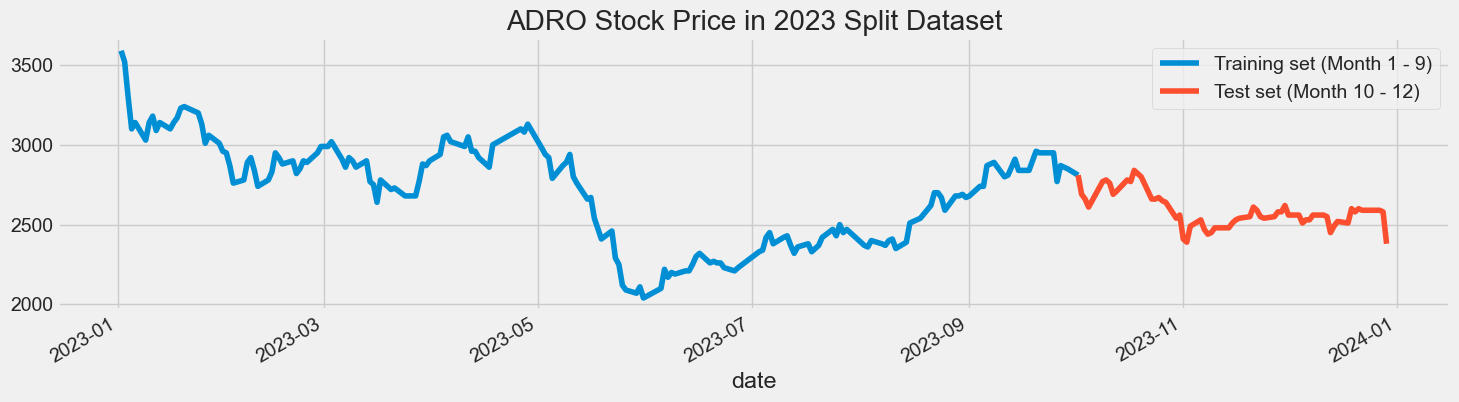

In [118]:
ADRO["close"]["2023-01":"2023-10-02"].plot(figsize=(16,4), legend=True)
ADRO["close"]["2023-10-02":"2023-12"].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Month 1 - 9)","Test set (Month 10 - 12)"])
plt.title('ADRO Stock Price in 2023 Split Dataset')
plt.show()

##### Normalize Dataset

In [119]:
#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(ADRO_medium_train)

##### Count Dataset Split

In [120]:
len_train = len(ADRO_medium_train)
len_test = len(ADRO_medium_test)
print(len_train, len_test)

177 63


##### 20 Timestep Dataset Preparation

In [121]:
# Since LSTMs store long term memory state, we create a data structure with 20 timesteps and 1 output
# So for each element of training set, we have 20 previous training set elements 
X_train = []
y_train = []
for i in range(20,len_train):
    X_train.append(training_set_scaled[i-20:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

##### Reshaping

In [122]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

#### LSTM Predictions

In [123]:
regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
5/5 [==============================] - 10s 56ms/step - loss: 0.3170
Epoch 2/50
5/5 [==============================] - 0s 59ms/step - loss: 0.0540
Epoch 3/50
5/5 [==============================] - 0s 59ms/step - loss: 0.0445
Epoch 4/50
5/5 [==============================] - 0s 59ms/step - loss: 0.0367
Epoch 5/50
5/5 [==============================] - 0s 51ms/step - loss: 0.0350
Epoch 6/50
5/5 [==============================] - 0s 53ms/step - loss: 0.0305
Epoch 7/50
5/5 [==============================] - 0s 51ms/step - loss: 0.0265
Epoch 8/50
5/5 [==============================] - 0s 52ms/step - loss: 0.0234
Epoch 9/50
5/5 [==============================] - 0s 53ms/step - loss: 0.0212
Epoch 10/50
5/5 [==============================] - 0s 54ms/step - loss: 0.0269
Epoch 11/50
5/5 [==============================] - 0s 52ms/step - loss: 0.0234
Epoch 12/50
5/5 [==============================] - 0s 53ms/step - loss: 0.0256
Epoch 13/50
5/5 [==============================] - 0s 51ms/s

In [124]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 20 entires of test set have 20 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing

dataset_total = pd.concat((ADRO["close"]["2023-01":"2023-10-02"],ADRO["close"]["2023-10-02":"2023-12"]),axis=0)
inputs = dataset_total[len(dataset_total)-len(ADRO_medium_test) - 20:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [125]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(20,len_test+20):
    X_test.append(inputs[i-20:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

2/2 [==============================] - 4s 22ms/step


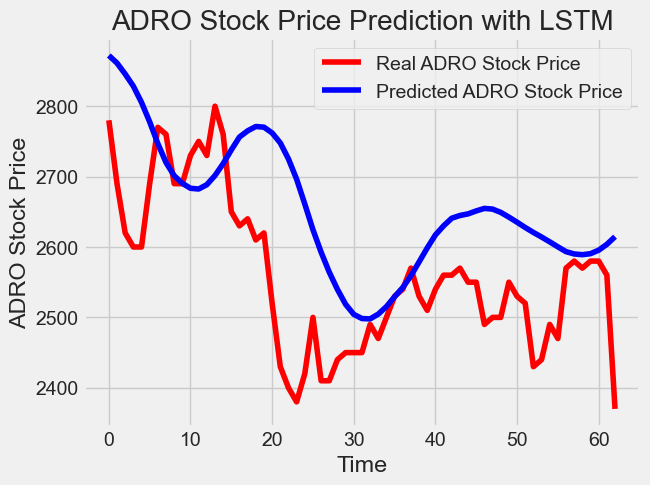

In [126]:
# Visualizing the results for LSTM
lstm_title = "with LSTM"
plot_predictions('ADRO', ADRO_medium_test,LSTM_predicted_stock_price, lstm_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\773518978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = LSTM_predicted_stock_price


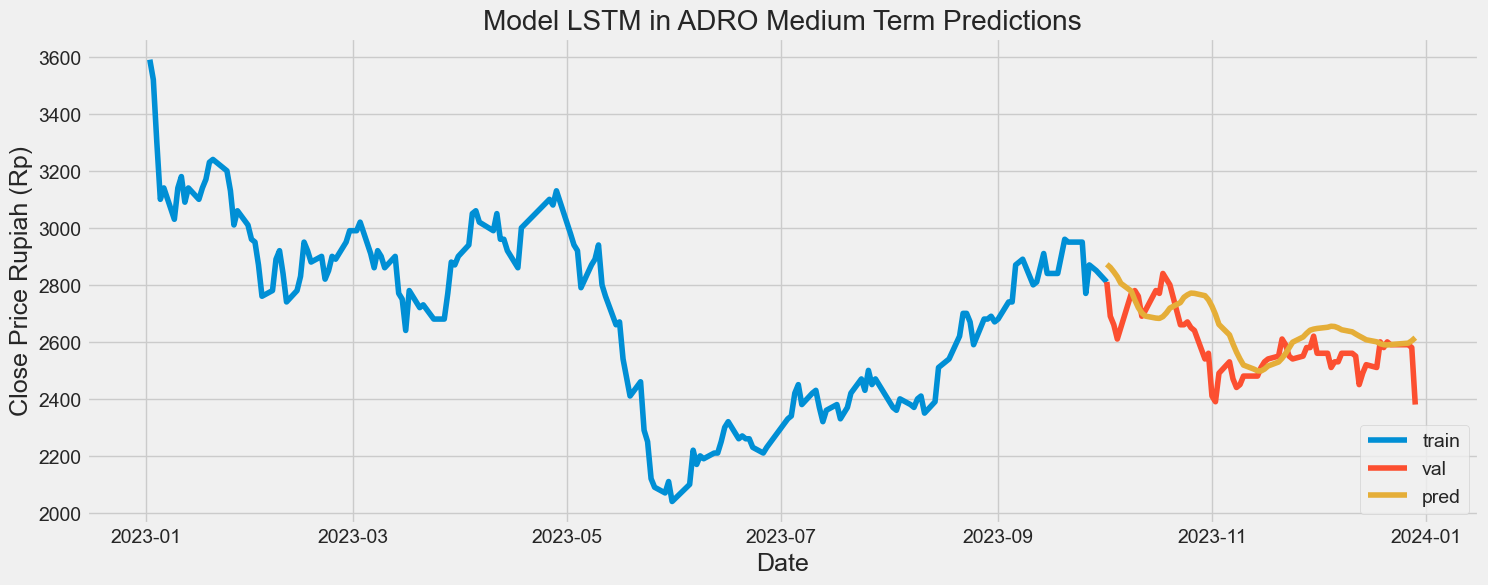

In [135]:
# Visualize the data
# Plot the data
train = ADRO["2023-01":"2023-10-02"]
valid = ADRO["2023-10-02":"2023-12"]
valid['pred'] = LSTM_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM in ADRO Medium Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [129]:
# Evaluating the sequence
return_rmse(ADRO_medium_test,LSTM_predicted_stock_price)
return_rmse_norm(ADRO_medium_test,LSTM_predicted_stock_price)

The root mean squared error is 134.29769864480667.
The root mean squared error after normalization is 0.2674749541102618.


0.2674749541102618

#### GRU Predictions

In [130]:
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
2/2 [==============================] - 10s 45ms/step - loss: 0.0371
Epoch 2/50
2/2 [==============================] - 0s 43ms/step - loss: 0.0350
Epoch 3/50
2/2 [==============================] - 0s 46ms/step - loss: 0.0367
Epoch 4/50
2/2 [==============================] - 0s 49ms/step - loss: 0.0326
Epoch 5/50
2/2 [==============================] - 0s 45ms/step - loss: 0.0328
Epoch 6/50
2/2 [==============================] - 0s 47ms/step - loss: 0.0366
Epoch 7/50
2/2 [==============================] - 0s 48ms/step - loss: 0.0340
Epoch 8/50
2/2 [==============================] - 0s 48ms/step - loss: 0.0322
Epoch 9/50
2/2 [==============================] - 0s 47ms/step - loss: 0.0318
Epoch 10/50
2/2 [==============================] - 0s 48ms/step - loss: 0.0324
Epoch 11/50
2/2 [==============================] - 0s 58ms/step - loss: 0.0306
Epoch 12/50
2/2 [==============================] - 0s 61ms/step - loss: 0.0315
Epoch 13/50
2/2 [==============================] - 0s 58ms/s

In [131]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(20,len_test+20):
    X_test.append(inputs[i-20:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

2/2 [==============================] - 3s 18ms/step


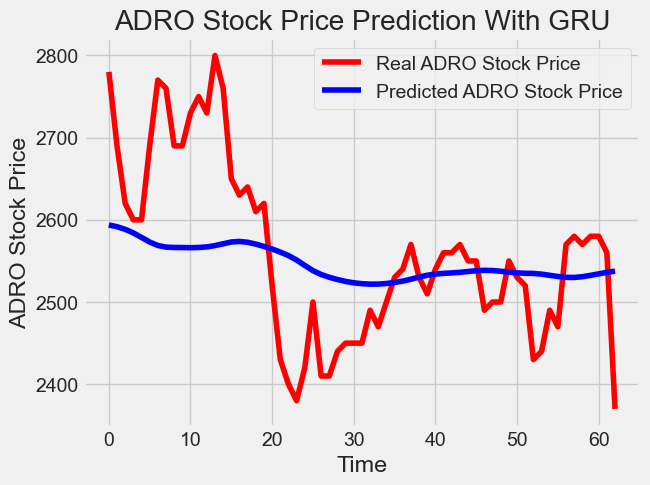

In [132]:
# Visualizing the results for GRU
gru_title = "With GRU"
plot_predictions("ADRO", ADRO_medium_test,GRU_predicted_stock_price, gru_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\3971688934.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = GRU_predicted_stock_price


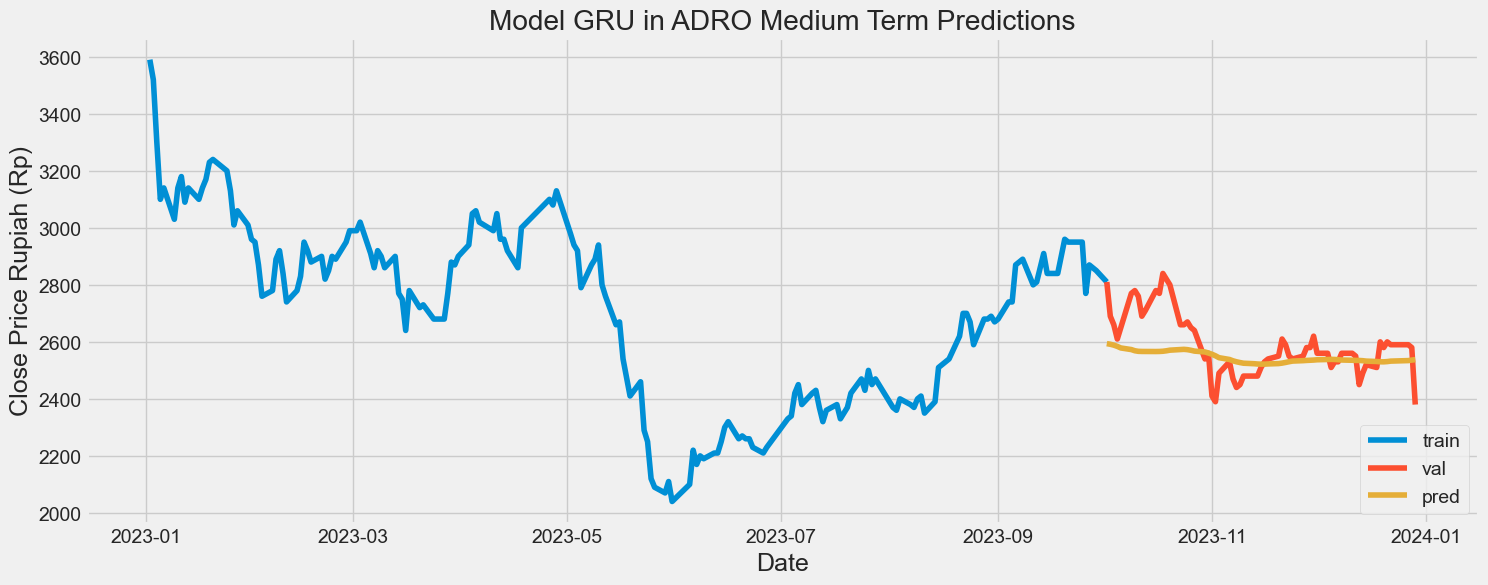

In [133]:
# Visualize the data
# Plot the data
train = ADRO["2023-01":"2023-10-02"]
valid = ADRO["2023-10-02":"2023-12"]
valid['pred'] = GRU_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model GRU in ADRO Medium Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [134]:
# Evaluating the sequence
return_rmse(ADRO_medium_test,GRU_predicted_stock_price)
return_rmse_norm(ADRO_medium_test,GRU_predicted_stock_price)

The root mean squared error is 96.3618486366012.
The root mean squared error after normalization is 0.2240973224107004.


0.2240973224107004

#### RNN Predictions

In [137]:
regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0394 - accuracy: 0.0000e+00

5/5 [==============================] - 0s 27ms/step - loss: 0.0346 - accuracy: 0.0064
Epoch 2/50
5/5 [==============================] - 0s 31ms/step - loss: 0.0364 - accuracy: 0.0127
Epoch 3/50
5/5 [==============================] - 0s 30ms/step - loss: 0.0246 - accuracy: 0.0127
Epoch 4/50
5/5 [==============================] - 0s 30ms/step - loss: 0.0383 - accuracy: 0.0127
Epoch 5/50
5/5 [==============================] - 0s 30ms/step - loss: 0.0366 - accuracy: 0.0127
Epoch 6/50
5/5 [==============================] - 0s 25ms/step - loss: 0.0296 - accuracy: 0.0127
Epoch 7/50
5/5 [==============================] - 0s 25ms/step - loss: 0.0274 - accuracy: 0.0127
Epoch 8/50
5/5 [==============================] - 0s 28ms/step - loss: 0.0307 - accuracy: 0.0127
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 0.0283 - accuracy: 0.0127
Epoch 10/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0324 - accuracy: 0.0064
Epoch 11/50
5/5 [=======================

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 20 entires of test set have 20 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing

dataset_total = pd.concat((ADRO["close"]["2023-01":"2023-10-02"],ADRO["close"]["2023-10-02":"2023-12"]),axis=0)
inputs = dataset_total[len(dataset_total)-len(ADRO_medium_test) - 20:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [138]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(20,len_test+20):
    X_test.append(inputs[i-20:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)

2/2 [==============================] - 1s 21ms/step


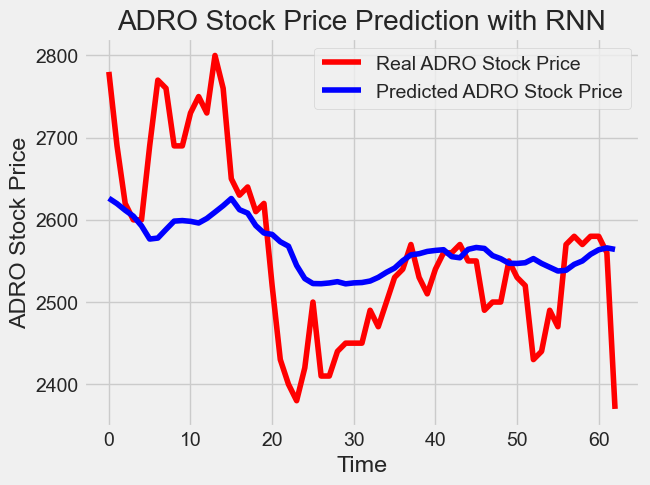

In [140]:
# Visualizing the results for rnn
rnn_title = "with RNN"
plot_predictions('ADRO', ADRO_medium_test,RNN_predicted_stock_price, rnn_title)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\3098864298.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = RNN_predicted_stock_price


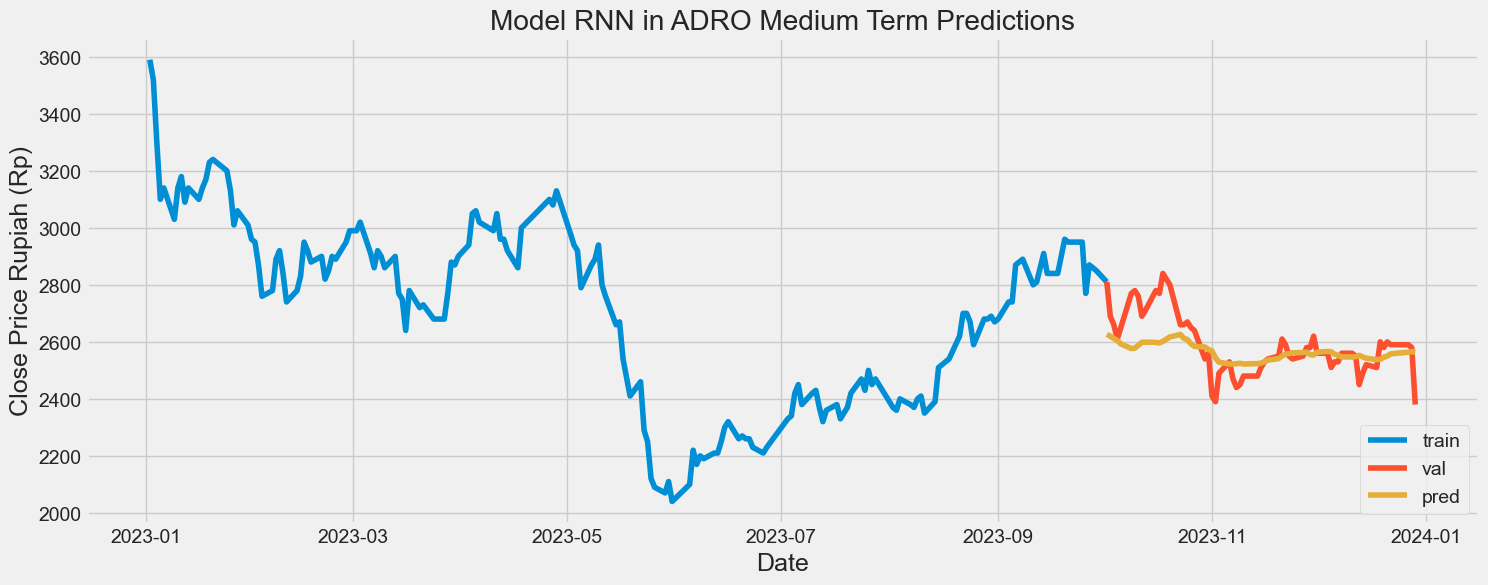

In [141]:
# Visualize the data
# Plot the data
train = ADRO["2023-01":"2023-10-02"]
valid = ADRO["2023-10-02":"2023-12"]
valid['pred'] = RNN_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model RNN in ADRO Medium Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


## Long Term Predictions
Long term prediction using in this program is prediction in several year to predict next year.
Data use for this predictions is data 2020 - July 2024.
Data train and test is:
1. Data Train
    * Year 2020 - 2022
2. Data Test
    * Year 2023 - July 2024

### ADRO

#### Data Split

In [142]:
ADRO_long_train = ADRO[:"2023"].iloc[:,3:4].values
ADRO_long_test = ADRO["2023":].iloc[:,3:4].values

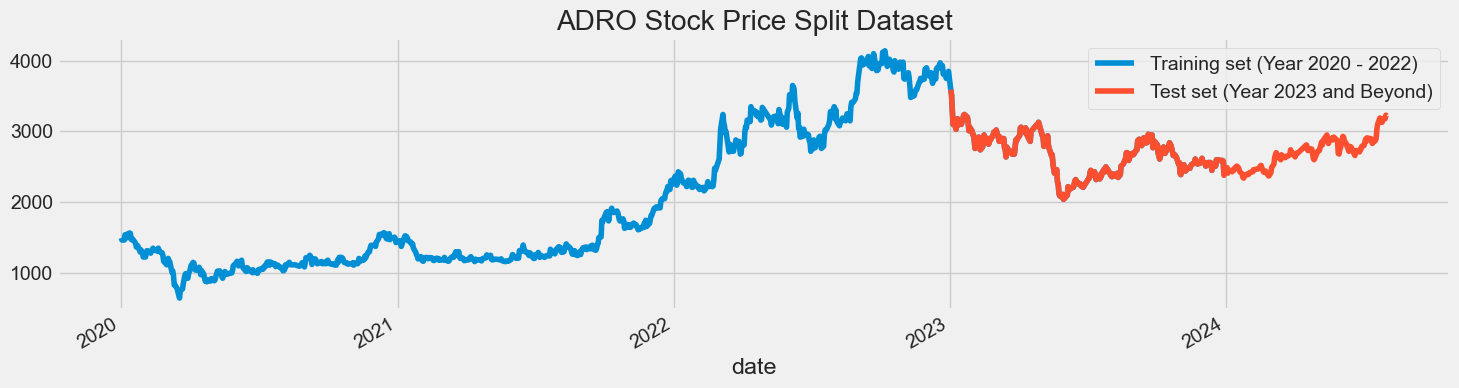

In [143]:
ADRO["close"][:"2023"].plot(figsize=(16,4), legend=True)
ADRO["close"]["2023":].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Year 2020 - 2022)","Test set (Year 2023 and Beyond)"])
plt.title('ADRO Stock Price Split Dataset')
plt.show()

In [144]:
#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(ADRO_long_train)

In [145]:
len_train = len(ADRO_long_train)
len_test = len(ADRO_long_test)
print(len_train, len_test)

974 372


In [147]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,len_train):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

#### LSTM Predictions

In [149]:
regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
29/29 [==============================] - 4s 126ms/step - loss: 0.0049
Epoch 2/50
29/29 [==============================] - 4s 121ms/step - loss: 0.0049
Epoch 3/50
29/29 [==============================] - 3s 120ms/step - loss: 0.0048
Epoch 4/50
29/29 [==============================] - 3s 115ms/step - loss: 0.0045
Epoch 5/50
29/29 [==============================] - 3s 114ms/step - loss: 0.0048
Epoch 6/50
29/29 [==============================] - 3s 118ms/step - loss: 0.0045
Epoch 7/50
29/29 [==============================] - 3s 115ms/step - loss: 0.0040
Epoch 8/50
29/29 [==============================] - 3s 109ms/step - loss: 0.0037
Epoch 9/50
29/29 [==============================] - 3s 110ms/step - loss: 0.0039
Epoch 10/50
29/29 [==============================] - 3s 114ms/step - loss: 0.0045
Epoch 11/50
29/29 [==============================] - 3s 112ms/step - loss: 0.0043
Epoch 12/50
29/29 [==============================] - 3s 113ms/step - loss: 0.0037
Epoch 13/50
29/29 [======

In [155]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing

dataset_total = pd.concat((ADRO["close"][:"2023"],ADRO["close"]["2023":]),axis=0)
inputs = dataset_total[len(dataset_total)-len(ADRO_long_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(20,len_test+20):
    X_test.append(inputs[i-20:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

# Visualize the data
# Plot the data
train = ADRO[:"2023"]
valid = ADRO["2023":]
valid['pred'] = LSTM_predicted_stock_price

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\1304130704.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = LSTM_predicted_stock_price


12/12 [==============================] - 0s 25ms/step


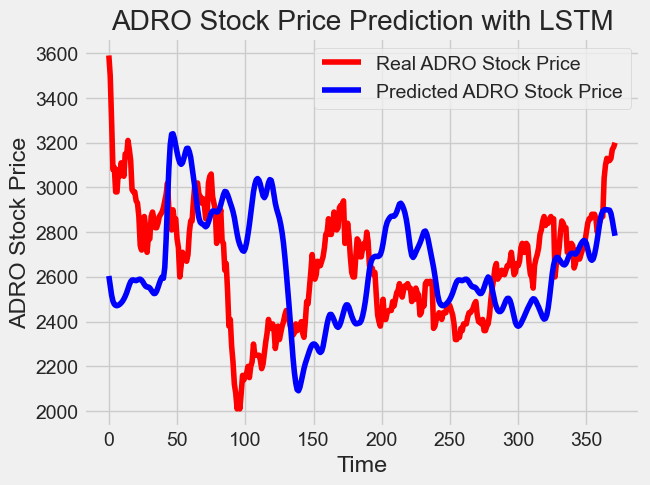

In [156]:
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)
# Visualizing the results for LSTM
lstm_title = "with LSTM"
plot_predictions('ADRO', ADRO_long_test,LSTM_predicted_stock_price, lstm_title)

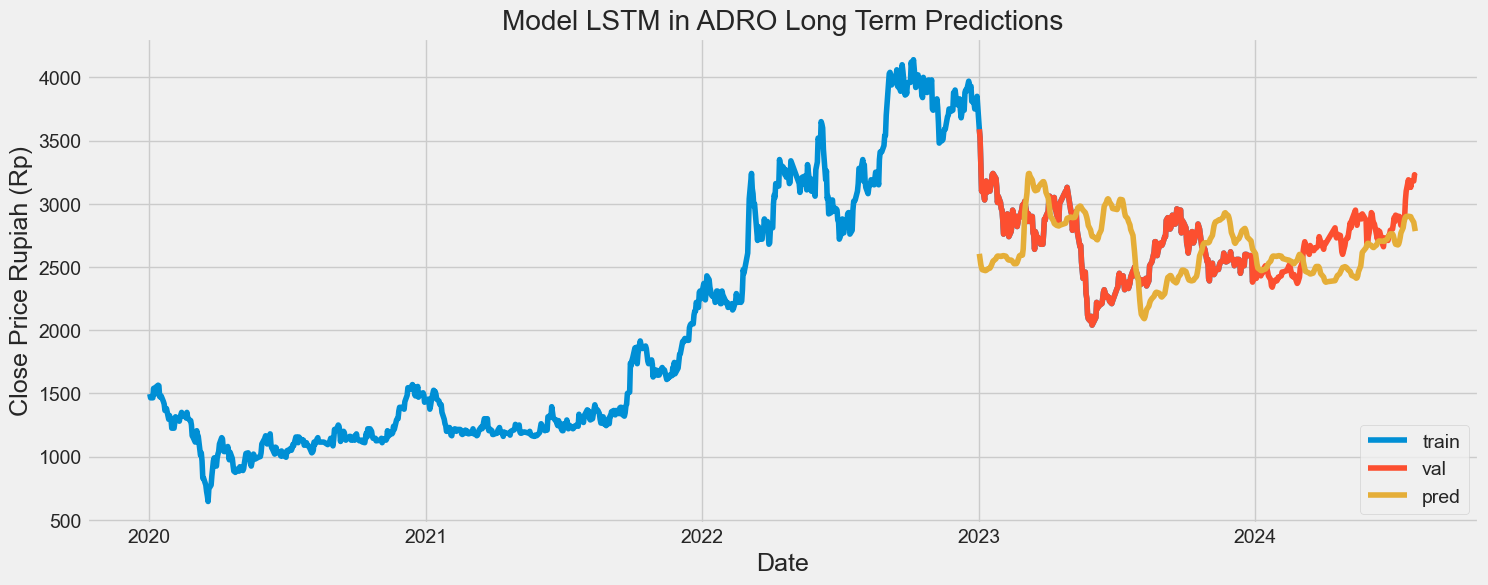

In [157]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM in ADRO Long Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()


In [159]:
# Evaluating the sequence
print(return_rmse(ADRO_long_test,LSTM_predicted_stock_price), return_rmse_norm(ADRO_long_test,LSTM_predicted_stock_price))

The root mean squared error is 352.813840792316.
The root mean squared error after normalization is 0.22329989923564306.
352.813840792316 0.22329989923564306


#### GRU Predictions

In [150]:

# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
7/7 [==============================] - 2s 238ms/step - loss: 0.0170
Epoch 2/50
7/7 [==============================] - 2s 262ms/step - loss: 0.0117
Epoch 3/50
7/7 [==============================] - 2s 232ms/step - loss: 0.0073
Epoch 4/50
7/7 [==============================] - 2s 343ms/step - loss: 0.0042
Epoch 5/50
7/7 [==============================] - 2s 260ms/step - loss: 0.0050
Epoch 6/50
7/7 [==============================] - 2s 349ms/step - loss: 0.0042
Epoch 7/50
7/7 [==============================] - 3s 364ms/step - loss: 0.0044
Epoch 8/50
7/7 [==============================] - 2s 264ms/step - loss: 0.0039
Epoch 9/50
7/7 [==============================] - 2s 235ms/step - loss: 0.0040
Epoch 10/50
7/7 [==============================] - 2s 278ms/step - loss: 0.0037
Epoch 11/50
7/7 [==============================] - 2s 250ms/step - loss: 0.0034
Epoch 12/50
7/7 [==============================] - 2s 237ms/step - loss: 0.0040
Epoch 13/50
7/7 [==============================] 

12/12 [==============================] - 0s 18ms/step


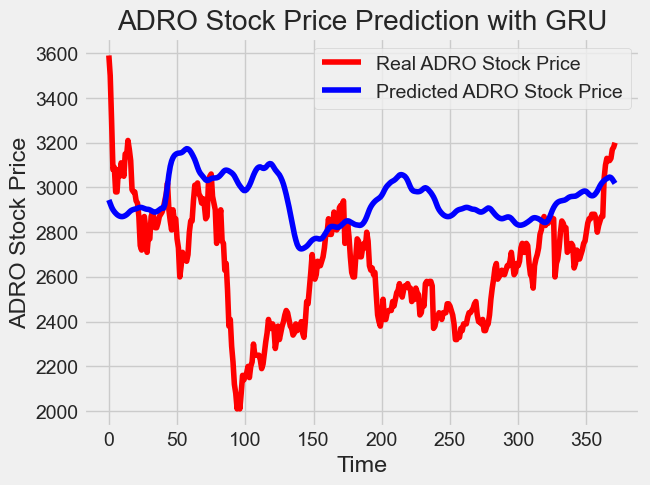

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\2203994294.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = GRU_predicted_stock_price


In [160]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
# Visualizing the results for GRU
GRU_title = "with GRU"
plot_predictions('ADRO', ADRO_long_test,GRU_predicted_stock_price, GRU_title)
# Visualize the data
# Plot the data
train = ADRO[:"2023"]
valid = ADRO["2023":]
valid['pred'] = GRU_predicted_stock_price

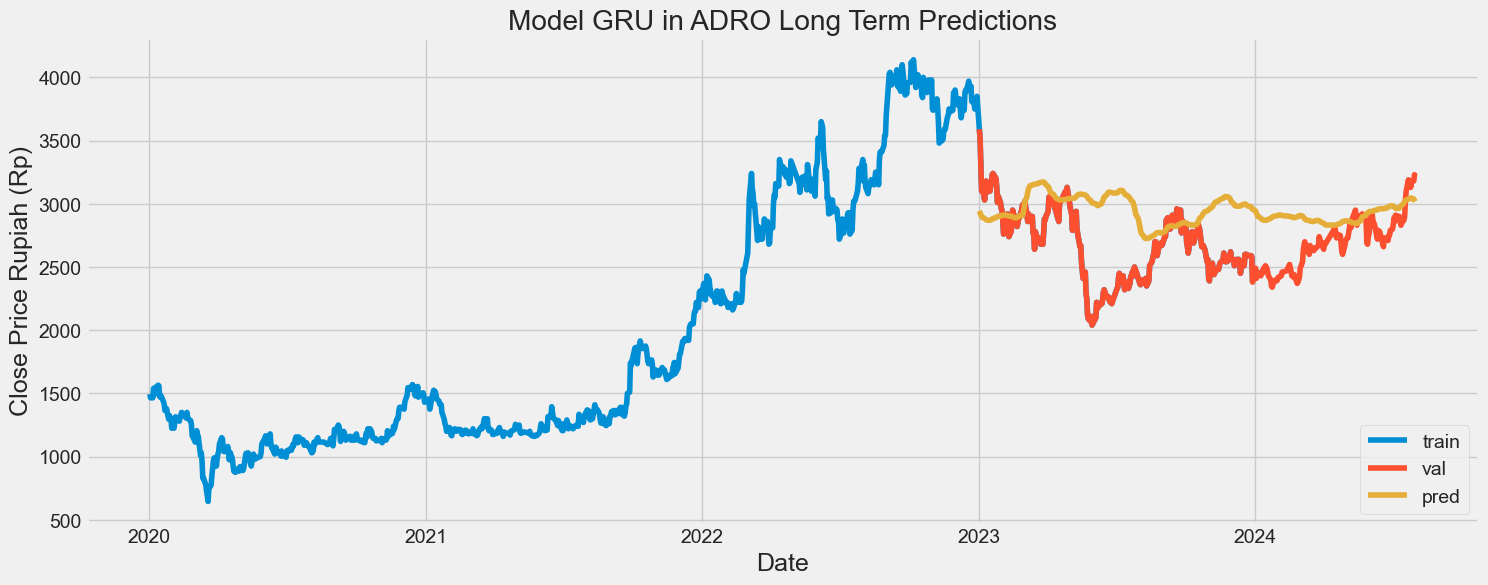

In [161]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model GRU in ADRO Long Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()



In [165]:
# Evaluating the sequence
print(return_rmse(ADRO_long_test,GRU_predicted_stock_price), return_rmse_norm(ADRO_long_test,GRU_predicted_stock_price))

The root mean squared error is 405.00913528964935.
The root mean squared error after normalization is 0.2563348957529426.
405.00913528964935 0.2563348957529426


#### RNN Predicitions

In [152]:
regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
29/29 [==============================] - 2s 58ms/step - loss: 0.0037 - accuracy: 0.0022
Epoch 2/50
29/29 [==============================] - 2s 54ms/step - loss: 0.0036 - accuracy: 0.0022
Epoch 3/50
29/29 [==============================] - 2s 56ms/step - loss: 0.0035 - accuracy: 0.0022
Epoch 4/50
29/29 [==============================] - 2s 57ms/step - loss: 0.0029 - accuracy: 0.0022
Epoch 5/50
29/29 [==============================] - 2s 54ms/step - loss: 0.0036 - accuracy: 0.0022
Epoch 6/50
29/29 [==============================] - 2s 53ms/step - loss: 0.0029 - accuracy: 0.0022
Epoch 7/50
29/29 [==============================] - 2s 54ms/step - loss: 0.0035 - accuracy: 0.0022
Epoch 8/50
29/29 [==============================] - 2s 54ms/step - loss: 0.0034 - accuracy: 0.0022
Epoch 9/50
29/29 [==============================] - 2s 54ms/step - loss: 0.0030 - accuracy: 0.0022
Epoch 10/50
29/29 [==============================] - 2s 56ms/step - loss: 0.0029 - accuracy: 0.0022
Epoch 11/

12/12 [==============================] - 0s 9ms/step


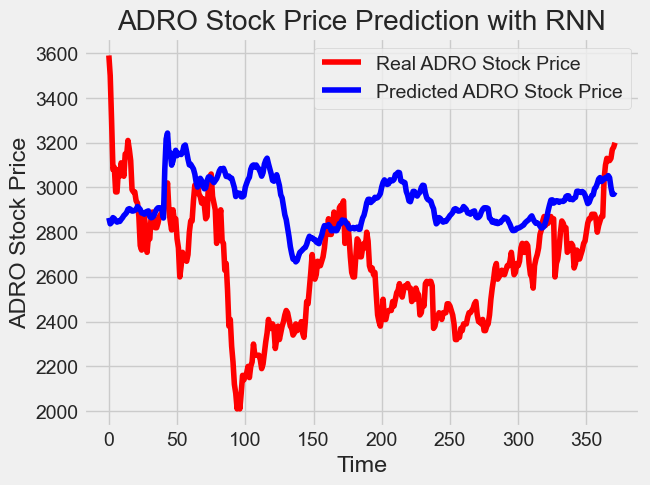

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6668\2874667067.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = RNN_predicted_stock_price


In [162]:
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)
# Visualizing the results for RNN
RNN_title = "with RNN"
plot_predictions('ADRO', ADRO_long_test,RNN_predicted_stock_price, RNN_title)
# Visualize the data
# Plot the data
train = ADRO[:"2023"]
valid = ADRO["2023":]
valid['pred'] = RNN_predicted_stock_price

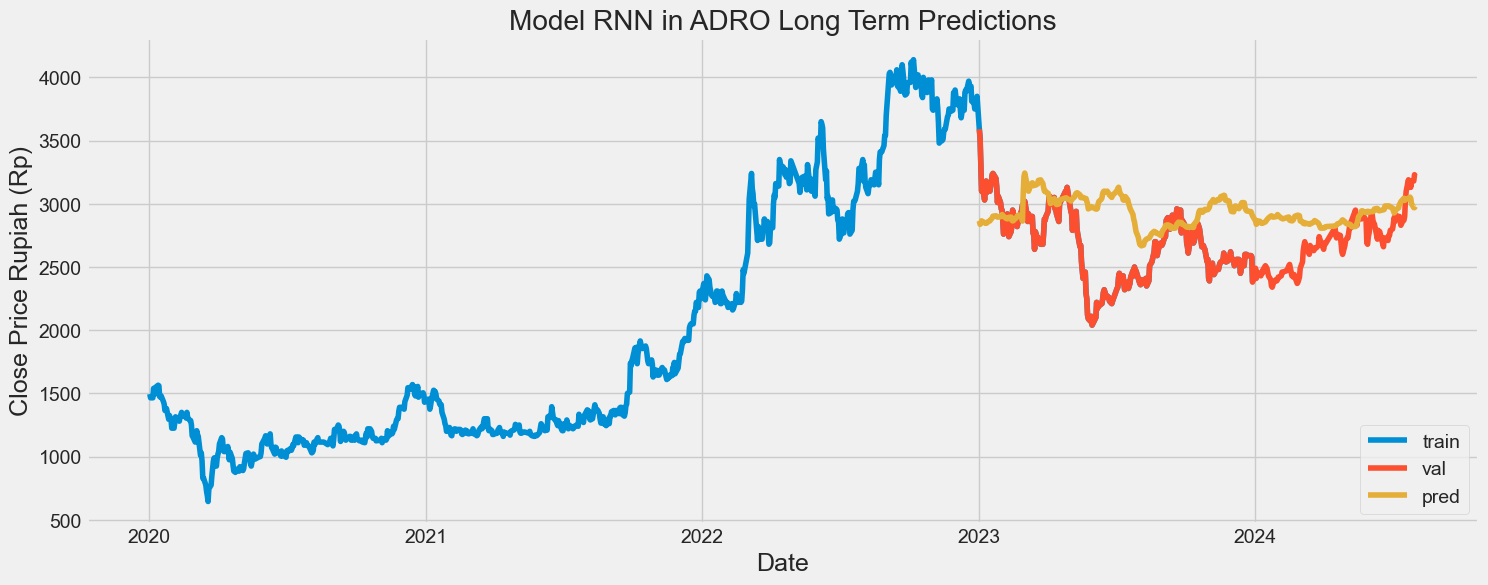

In [163]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model RNN in ADRO Long Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'pred']])
plt.legend(['train', 'val', 'pred'], loc='lower right')
plt.show()



In [164]:
# Evaluating the sequence
print(return_rmse(ADRO_long_test,RNN_predicted_stock_price), return_rmse_norm(ADRO_long_test,RNN_predicted_stock_price))

The root mean squared error is 395.57558631288254.
The root mean squared error after normalization is 0.2503642951347358.
395.57558631288254 0.2503642951347358
